In [44]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Оценка стоимости кварталов

In [45]:
blocks_gdf = gdf = pd.read_pickle("../data/blocks.pickle")
blocks_gdf.columns

Index(['geometry', 'residential', 'business', 'recreation', 'industrial',
       'transport', 'special', 'agriculture', 'land_use', 'share',
       ...
       'capacity_prison', 'count_prison', 'capacity_landfill',
       'count_landfill', 'capacity_plant_nursery', 'count_plant_nursery',
       'capacity_greenhouse_complex', 'count_greenhouse_complex',
       'capacity_warehouse', 'count_warehouse'],
      dtype='object', length=136)

In [46]:
# cadastr_land = gpd.read_parquet('data/spb_land_cad.parquet')
cadastr_blocks = gpd.read_parquet('/home/mvin/blocksnet-1/examples/data/spb_bloks_price.parquet')
cadastr_blocks.head()

cadastralDistrictsCode                                   readable_address  \
0                      78  Санкт-Петербург, город Зеленогорск, Решетников...   
1                      78  г.Санкт-Петербург, город Зеленогорск, Решетник...   
2                      78  Санкт-Петербург, город Зеленогорск, Красавица,...   
3                      78  Санкт-Петербург, город Зеленогорск, Решетников...   
4                      78  Санкт-Петербург, город Зеленогорск, Решетников...   

     cost_value  cost_index land_record_category_type  \
0 10,833,260.98    5,846.34  Земли населенных пунктов   
1  6,533,139.72    5,444.28  Земли населенных пунктов   
2     16,395.97    1,366.33  Земли населенных пунктов   
3  8,425,371.37    5,513.99  Земли населенных пунктов   
4 11,430,710.60    5,715.36  Земли населенных пунктов   

               permitted_use_established_by_document  specified_area  \
0  для размещения индивидуального жилого дома (ин...        1,852.00   
1  для размещения индивидуального жилого дома (ин...        1,200.00   
2   Для размещения объектов коммунального  хозяйства           12.00   
3  Для размещения индивидуального (одноквартирног...        1,528.00   
4  для размещения индивидуального жилого дома (ин...        2,000.00   

                                            geometry  
0  POLYGON ((3306132.351 8453357.197, 3306131.265...  
1  POLYGON ((3306613.198 8453876.707, 3306609.831...  
2  POLYGON ((3311932.709 8453466.264, 3311927.608...  
3  POLYGON ((3306341.721 8454345.055, 3306347.49 ...  
4  POLYGON ((3306583.407 8453412.704, 3306580.412...

In [47]:
cadastr_blocks['log_cost_index'] = np.log1p(cadastr_blocks['cost_index'])

In [48]:
# blocks_gdf['log_population'] = np.log1p(blocks_gdf['population'])

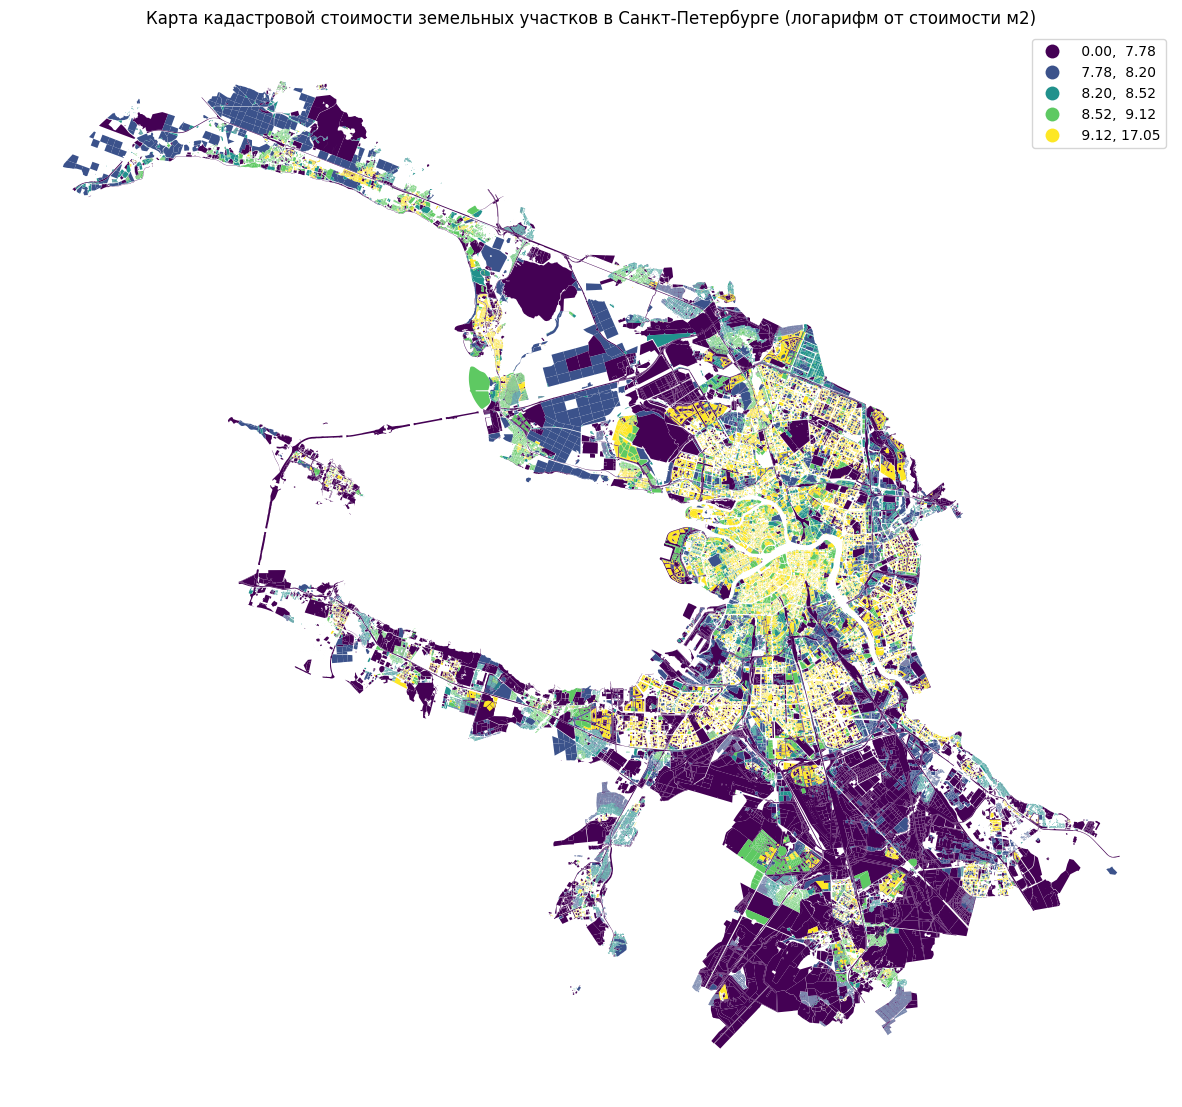

In [49]:
# Картируем лог-цену
cadastr_blocks.plot(
    column='log_cost_index',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта кадастровой стоимости земельных участков в Санкт-Петербурге (логарифм от стоимости м2)')

plt.show()

In [50]:
import geopandas as gpd

# — 1. Клонируем оригиналы, чтобы не портить исходники
blocks = blocks_gdf.copy()
cad    = cadastr_blocks.copy()

# — 2. Приводим к единому CRS (он нужен для корректных площадей)
if blocks.crs != cad.crs:
    cad = cad.to_crs(blocks.crs)

# — 3. Считаем полную площадь cadastral-полигонов
cad['cad_area'] = cad.geometry.area

# — 4. Явно добавляем в blocks колонку block_id из индекса
blocks['block_id'] = blocks.index

# — 5. Пересечение кварталов и кадастра
inter = gpd.overlay(
    blocks[['block_id', 'geometry']],
    cad   [['cost_value', 'cad_area', 'geometry']],
    how='intersection'
)

# — 6. Площадь каждого куска пересечения
inter['int_area'] = inter.geometry.area

# — 7. Вклады стоимости пропорционально площади
inter['cost_contrib'] = inter['cost_value'] * inter['int_area'] / inter['cad_area']

# — 8. Суммируем для каждого квартала
block_costs = (
    inter
    .groupby('block_id', as_index=False)['cost_contrib']
    .sum()
    .rename(columns={'cost_contrib':'total_cost_value'})
)

# — 9. Мерджим обратно в blocks, заполняем пропуски нулями
blocks = blocks.merge(block_costs, on='block_id', how='left')
blocks['total_cost_value'] = blocks['total_cost_value'].fillna(0)

# — 10. При желании убираем служебный block_id (или возвращаем исходный индекс)
blocks = blocks.drop(columns=['block_id'])
blocks


/tmp/ipykernel_45835/3193496010.py:18: UserWarning: `keep_geom_type=True` in overlay resulted in 64 dropped geometries of different geometry types than df1 has. Set `keep_geom_type=False` to retain all geometries
  inter = gpd.overlay(


geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.00        0.00       1.00     0.00         0.00   
1         0.00        0.08        0.00       0.40     0.00         0.42   
2         0.00        0.00        0.00       0.00     0.00         0.00   
3         0.00        0.27        0.00       0.00     0.00         0.00   
4         0.00        0.00        0.00       0.14     0.00         0.40   
...        ...         ...         ...        ...      ...          ...   
9363      0.00        0.00        0.00       0.06     0.00         0.00   
9364      0.00        0.27        0.00       0.61     0.00         0.00   
9365      0.00        0.76        0.00       0.23     0.00         0.00   
9366      0.00        0.00        0.47       0.12     0.00         0.00   
9367      0.00        0.00        0.00       0.20     0.00         0.00   

                 land_use  share  ...  count_prison  capacity_landfill  \
0       LandUse.TRANSPORT   1.00  ...          0.00               0.00   
1     LandUse.AGRICULTURE   0.42  ...          0.00               0.00   
2     LandUse.RESIDENTIAL   1.00  ...          0.00               0.00   
3     LandUse.RESIDENTIAL   0.73  ...          0.00               0.00   
4     LandUse.RESIDENTIAL   0.45  ...          0.00               0.00   
...                   ...    ...  ...           ...                ...   
9363  LandUse.RESIDENTIAL   0.94  ...          0.00               0.00   
9364    LandUse.TRANSPORT   0.61  ...          0.00               0.00   
9365   LandUse.RECREATION   0.76  ...          0.00               0.00   
9366   LandUse.INDUSTRIAL   0.47  ...          0.00               0.00   
9367  LandUse.RESIDENTIAL   0.69  ...          0.00               0.00   

      count_landfill  capacity_plant_nursery  count_plant_nursery  \
0               0.00                    0.00                 0.00   
1               0.00                    0.00                 0.00   
2               0.00                    0.00                 0.00   
3               0.00                    0.00                 0.00   
4               0.00                   30.00                 1.00   
...              ...                     ...                  ...   
9363            0.00                    0.00                 0.00   
9364            0.00                    0.00                 0.00   
9365            0.00                    0.00                 0.00   
9366            0.00                    0.00                 0.00   
9367            0.00                    0.00                 0.00   

      capacity_greenhouse_complex  count_greenhouse_complex  \
0                            0.00                      0.00   
1                            0.00                      0.00   
2                            0.00                      0.00   
3                            0.00                      0.00   
4                            0.00                      0.00   
...                           ...                       ...   
9363                         0.00                      0.00   
9364                         0.00                      0.00

In [51]:
# 1. Если CRS географический (deg), переведём в метрический (например, Меркатор)
if blocks.crs.is_geographic:
    blocks = blocks.to_crs(epsg=3857)

# 2. Считаем площадь каждого квартала в м²
blocks['site_area'] = blocks.geometry.area

# 3. Считаем цену за квадратный метр
blocks['price_per_sqm'] = blocks['total_cost_value'] / blocks['site_area']
# blocks = blocks.drop(columns=['site_area'])
# 4. (Опционально) уберём бесконечные и NaN
blocks.loc[~blocks['price_per_sqm'].replace([np.inf, -np.inf], np.nan).notna(), 'price_per_sqm'] = 0
blocks = blocks.to_crs(epsg=32636)
blocks.head()
# Результат: в blocks['price_per_sqm'] — стоимость одного квадрата метра для каждого квартала


geometry  residential  business  \
0  POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00      0.00   
1  POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10      0.00   
2  POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00      0.00   
3  POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73      0.00   
4  POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45      0.00   

   recreation  industrial  transport  special  agriculture  \
0        0.00        0.00       1.00     0.00         0.00   
1        0.08        0.00       0.40     0.00         0.42   
2        0.00        0.00       0.00     0.00         0.00   
3        0.27        0.00       0.00     0.00         0.00   
4        0.00        0.00       0.14     0.00         0.40   

              land_use  share  ...  count_landfill  capacity_plant_nursery  \
0    LandUse.TRANSPORT   1.00  ...            0.00                    0.00   
1  LandUse.AGRICULTURE   0.42  ...            0.00                    0.00   
2  LandUse.RESIDENTIAL   1.00  ...            0.00                    0.00   
3  LandUse.RESIDENTIAL   0.73  ...            0.00                    0.00   
4  LandUse.RESIDENTIAL   0.45  ...            0.00                   30.00   

   count_plant_nursery  capacity_greenhouse_complex  count_greenhouse_complex  \
0                 0.00                         0.00                      0.00   
1                 0.00                         0.00                      0.00   
2                 0.00                         0.00                      0.00   
3                 0.00                         0.00                      0.00   
4                 1.00                         0.00                      0.00   

   capacity_warehouse  count_warehouse  total_cost_value  site_area  \
0                0.00             0.00              0.00       0.03   
1                0.00             0.00    129,202,173.99 137,101.09   
2                0.00             0.00    185,946,167.88  95,239.08   
3                0.00             0.00    189,788,550.29 125,919.33   
4                0.00             0.00    373,309,691.92 169,860.16   

   price_per_sqm  
0           0.00  
1         942.39  
2       1,952.41  
3       1,507.22  
4       2,197.75  

[5 rows x 139 columns]

In [52]:
blocks['log_total_price'] = np.log1p(blocks['total_cost_value'])
blocks['log_price'] = np.log1p(blocks['price_per_sqm'])

count   9,368.00
mean       17.46
std         5.09
min         0.00
25%        17.50
50%        18.74
75%        19.91
max        23.88
Name: log_total_price, dtype: float64


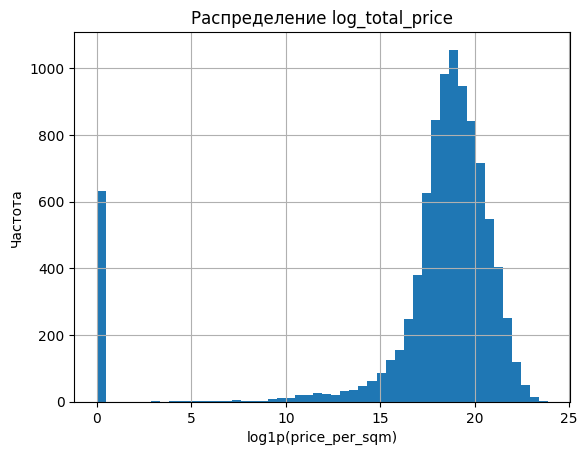

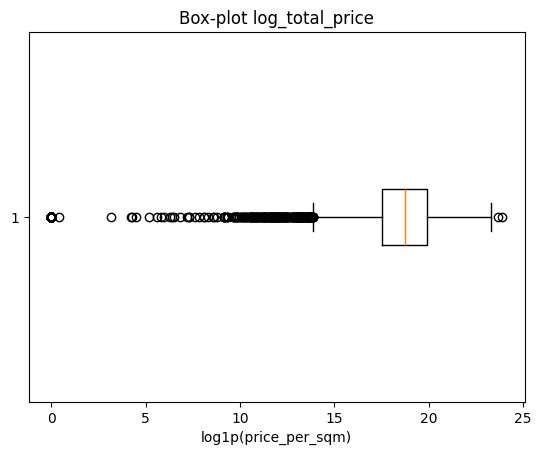

In [53]:
# Быстрая статистика
print(blocks['log_total_price'].describe())

# Гистограмма
plt.figure()
blocks['log_total_price'].hist(bins=50)
plt.xlabel('log1p(price_per_sqm)')
plt.ylabel('Частота')
plt.title('Распределение log_total_price')
plt.show()

# Box-plot
plt.figure()
plt.boxplot(blocks['log_total_price'].dropna(), vert=False)
plt.xlabel('log1p(price_per_sqm)')
plt.title('Box-plot log_total_price')
plt.show()


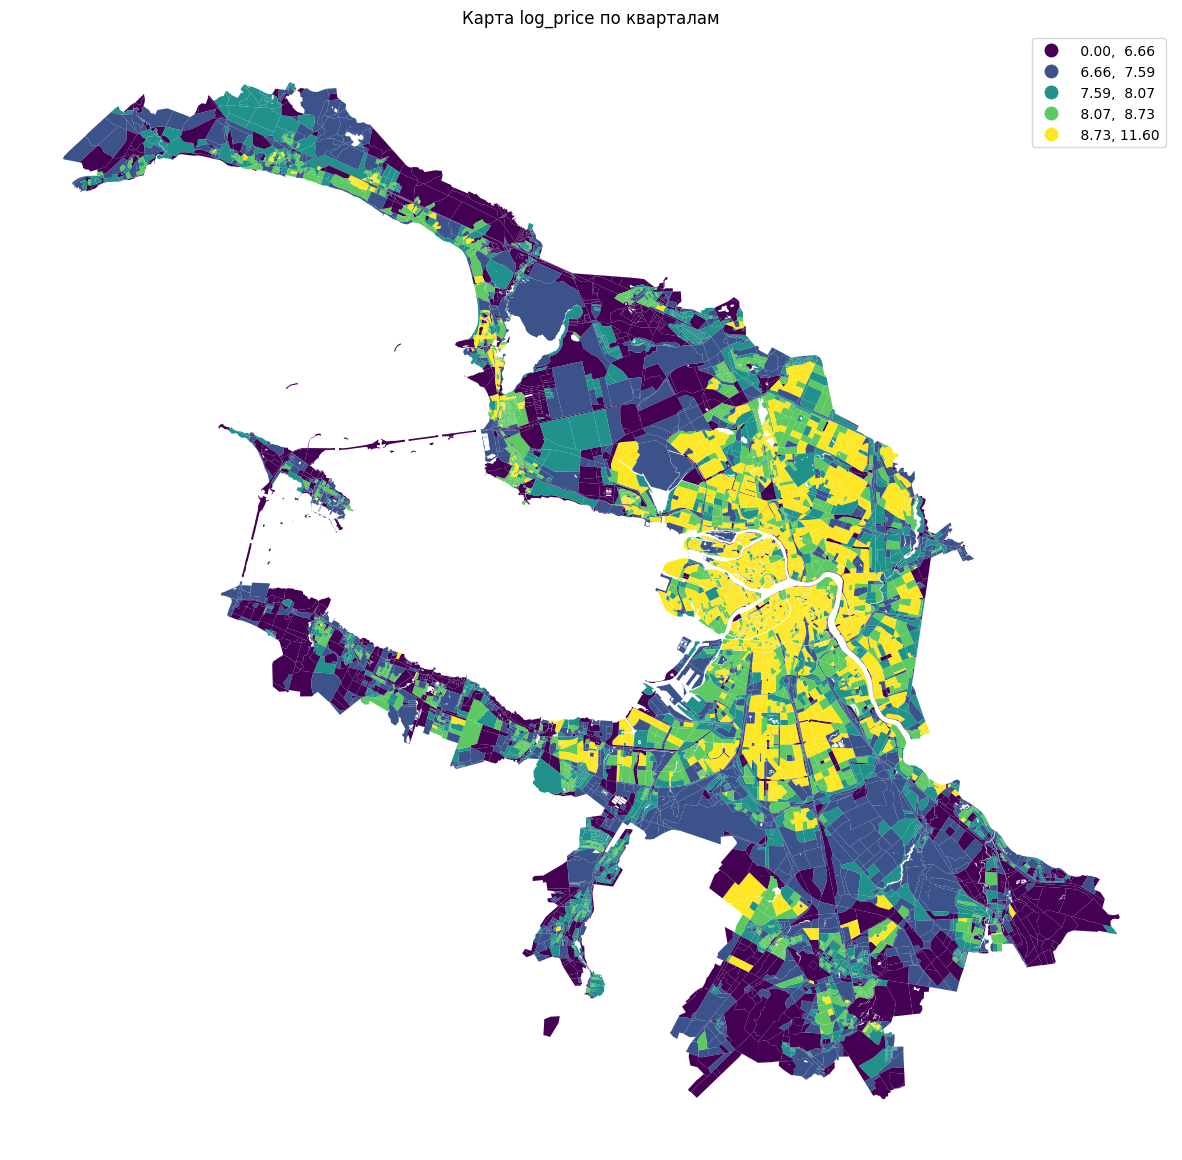

In [54]:
# Картируем лог-цену
blocks.plot(
    column='log_price',
    scheme='quantiles',
    legend=True,
    figsize=(15,15),
    cmap='viridis'
).set_axis_off()
plt.title('Карта log_price по кварталам')

plt.show()



In [55]:
# from sklearn.preprocessing import StandardScaler

# scaler = StandardScaler()
# blocks['log_std'] = scaler.fit_transform(
#     blocks[['log_price']]
# )

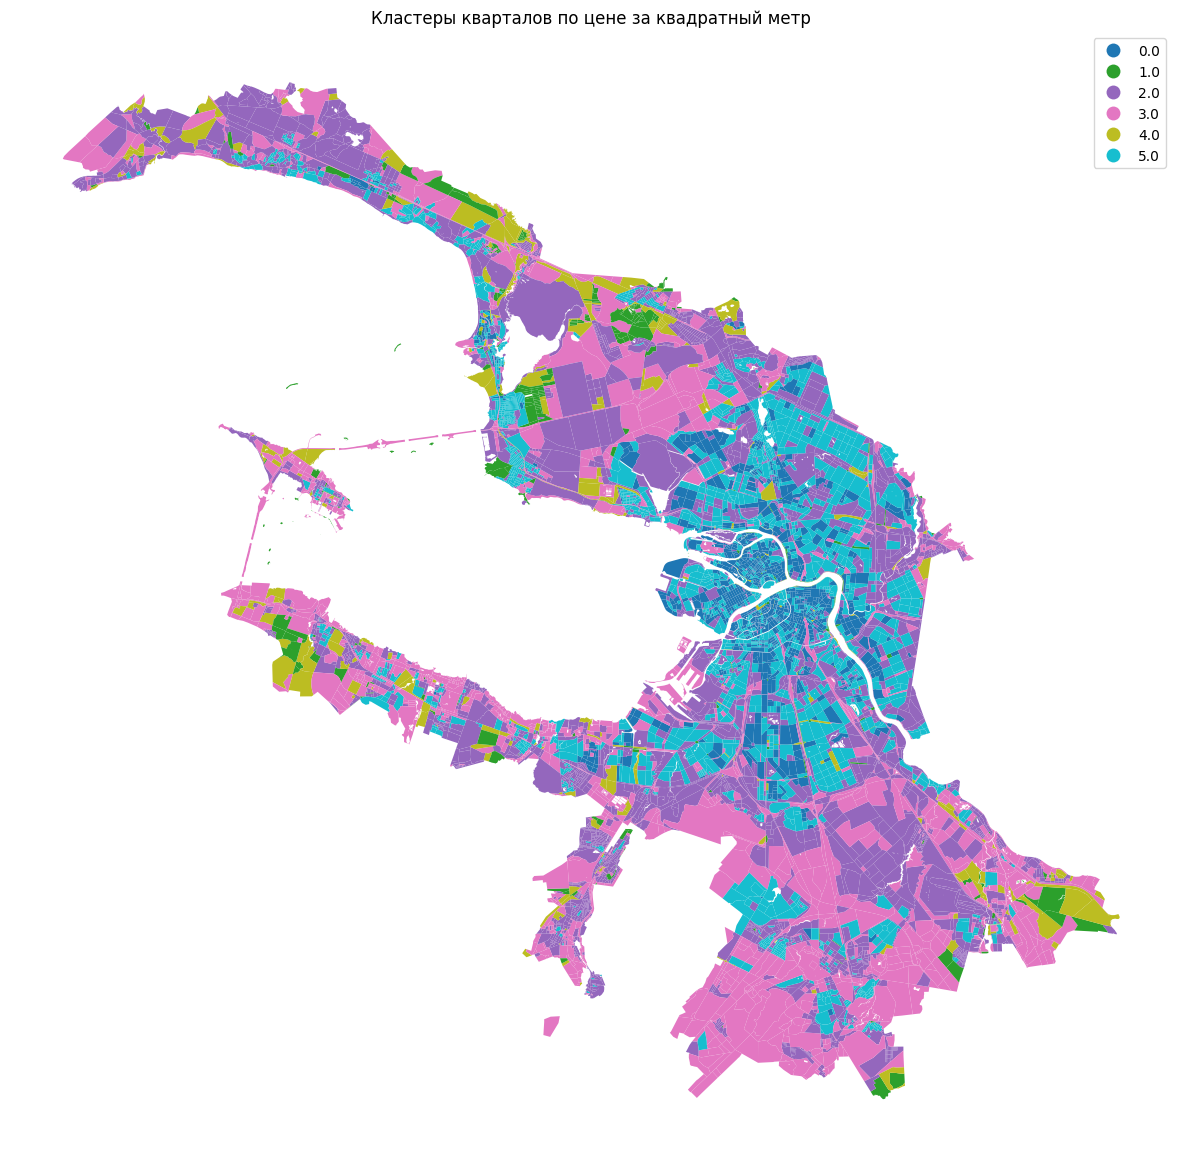

In [56]:
from sklearn.cluster import KMeans

# Берём только ненулевые и не NaN
X = blocks[['log_price']].dropna()

kmeans = KMeans(n_clusters=6, random_state=0)
blocks.loc[X.index, 'cluster'] = kmeans.fit_predict(X)

# Визуализируем
blocks.plot(
    column='cluster',
    categorical=True,
    legend=True,
    figsize=(15,15)
).set_axis_off()
plt.title('Кластеры кварталов по цене за квадратный метр')
plt.show()


In [57]:
# # Собираем все имена колонок, которые начинаются на 'capacity'
# cols_to_drop = [col for col in blocks.columns if col.startswith('capacity')]
# blocks = blocks.drop(columns=cols_to_drop)
# cols_to_drop = [col for col in blocks.columns if col.startswith('count')]

# # Удаляем их сразу все
# blocks = blocks.drop(columns=cols_to_drop)
# blocks.columns

In [58]:
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.00        0.00       1.00     0.00         0.00   
1         0.00        0.08        0.00       0.40     0.00         0.42   
2         0.00        0.00        0.00       0.00     0.00         0.00   
3         0.00        0.27        0.00       0.00     0.00         0.00   
4         0.00        0.00        0.00       0.14     0.00         0.40   
...        ...         ...         ...        ...      ...          ...   
9363      0.00        0.00        0.00       0.06     0.00         0.00   
9364      0.00        0.27        0.00       0.61     0.00         0.00   
9365      0.00        0.76        0.00       0.23     0.00         0.00   
9366      0.00        0.00        0.47       0.12     0.00         0.00   
9367      0.00        0.00        0.00       0.20     0.00         0.00   

                 land_use  share  ...  capacity_greenhouse_complex  \
0       LandUse.TRANSPORT   1.00  ...                         0.00   
1     LandUse.AGRICULTURE   0.42  ...                         0.00   
2     LandUse.RESIDENTIAL   1.00  ...                         0.00   
3     LandUse.RESIDENTIAL   0.73  ...                         0.00   
4     LandUse.RESIDENTIAL   0.45  ...                         0.00   
...                   ...    ...  ...                          ...   
9363  LandUse.RESIDENTIAL   0.94  ...                         0.00   
9364    LandUse.TRANSPORT   0.61  ...                         0.00   
9365   LandUse.RECREATION   0.76  ...                         0.00   
9366   LandUse.INDUSTRIAL   0.47  ...                         0.00   
9367  LandUse.RESIDENTIAL   0.69  ...                         0.00   

      count_greenhouse_complex  capacity_warehouse  count_warehouse  \
0                         0.00                0.00             0.00   
1                         0.00                0.00             0.00   
2                         0.00                0.00             0.00   
3                         0.00                0.00             0.00   
4                         0.00                0.00             0.00   
...                        ...                 ...              ...   
9363                      0.00                0.00             0.00   
9364                      0.00                0.00             0.00   
9365                      0.00                0.00             0.00   
9366                      0.00              150.00             1.00   
9367                      0.00                0.00             0.00   

      total_cost_value  site_area  price_per_sqm  log_total_price  log_price  \
0                 0.00       0.03           0.00             0.00       0.00   
1       129,202,173.99 137,101.09         942.39            18.68       6.85   
2       185,946,167.88  95,239.08       1,952.41            19.04       7.58   
3       189,788,550.29 125,919.33       1,507.22            19.06       7.32   
4       373,309,691.92 169,860.16       2,197.75            19.74       7.70   
...                ...        ...            ...              ...        ...   
9363    219,055,949.97  16,

In [59]:
blocks['land_use'] = (
    blocks['land_use']
    .astype(str)
    .str.replace(r'^LandUse\.', '', regex=True)
)

In [60]:
# blocks.to_file('blocks2.geojson', driver='GeoJSON')

## Дополнитльные метрики

In [61]:
# blocks = gdf = gpd.read_file('/Users/mvin/Code/blocksnet/examples/data/blocks2/blocks2.geojson')

In [62]:
from blocksnet.analysis.indicators import calculate_density_indicators 

blocks_df = calculate_density_indicators(blocks[[
    'site_area',
    'footprint_area',
    'build_floor_area',
    'living_area'
]])
blocks_df

2025-07-03 16:06:33.682 | WARNING  | blocksnet.analysis.indicators.density.schemas:_before_validate:19 - The non_living_area is not in columns, restoring


site_area  footprint_area  build_floor_area  living_area  \
0          0.03            0.00              0.00         0.00   
1    137,101.09           69.02             69.02         0.00   
2     95,239.08        5,853.86          6,106.76     4,197.19   
3    125,919.33        4,214.83          4,375.48     3,033.80   
4    169,860.16       13,392.85         31,242.32    20,860.97   
...         ...             ...               ...          ...   
9363  16,802.38        4,360.96         21,549.42     9,911.58   
9364  47,637.96       14,963.57         73,149.19         0.00   
9365  64,487.70           25.67             25.67         0.00   
9366  42,988.40       12,973.89         52,737.33         0.00   
9367  74,469.97        8,400.63         50,804.76    33,728.39   

      non_living_area  fsi  gsi  mxi    l      osr  share_living  \
0                0.00 0.00 0.00  NaN  NaN      inf           NaN   
1               69.02 0.00 0.00 0.00 1.00 1,985.45          0.00   
2            1,909.57 0.06 0.06 0.69 1.04    14.64          0.72   
3            1,341.69 0.03 0.03 0.69 1.04    27.82          0.72   
4           10,381.36 0.18 0.08 0.67 2.33     5.01          1.56   
...               ...  ...  ...  ...  ...      ...           ...   
9363        11,637.84 1.28 0.26 0.46 4.94     0.58          2.27   
9364        73,149.19 1.54 0.31 0.00 4.89     0.45          0.00   
9365            25.67 0.00 0.00 0.00 1.00 2,510.80          0.00   
9366        52,737.33 1.23 0.30 0.00 4.06     0.57          0.00   
9367        17,076.37 0.68 0.11 0.66 6.05     1.30          4.01   

      share_non_living  
0                  NaN  
1                 1.00  
2                 0.33  
3                 0.32  
4                 0.78  
...                ...  
9363              2.67  
9364              4.89  
9365              1.00  
9366              4.06  
9367              2.03  

[9368 rows x 12 columns]

In [63]:
blocks.loc[:, blocks_df.columns] = blocks_df
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.00        0.00       1.00     0.00         0.00   
1         0.00        0.08        0.00       0.40     0.00         0.42   
2         0.00        0.00        0.00       0.00     0.00         0.00   
3         0.00        0.27        0.00       0.00     0.00         0.00   
4         0.00        0.00        0.00       0.14     0.00         0.40   
...        ...         ...         ...        ...      ...          ...   
9363      0.00        0.00        0.00       0.06     0.00         0.00   
9364      0.00        0.27        0.00       0.61     0.00         0.00   
9365      0.00        0.76        0.00       0.23     0.00         0.00   
9366      0.00        0.00        0.47       0.12     0.00         0.00   
9367      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  log_total_price  log_price  cluster  fsi  gsi  \
0       TRANSPORT   1.00  ...             0.00       0.00     1.00 0.00 0.00   
1     AGRICULTURE   0.42  ...            18.68       6.85     3.00 0.00 0.00   
2     RESIDENTIAL   1.00  ...            19.04       7.58     2.00 0.06 0.06   
3     RESIDENTIAL   0.73  ...            19.06       7.32     2.00 0.03 0.03   
4     RESIDENTIAL   0.45  ...            19.74       7.70     2.00 0.18 0.08   
...           ...    ...  ...              ...        ...      ...  ...  ...   
9363  RESIDENTIAL   0.94  ...            19.20       9.48     0.00 1.28 0.26   
9364    TRANSPORT   0.61  ...            19.74       8.97     5.00 1.54 0.31   
9365   RECREATION   0.76  ...            18.96       7.89     2.00 0.00 0.00   
9366   INDUSTRIAL   0.47  ...            19.37       8.70     5.00 1.23 0.30   
9367  RESIDENTIAL   0.69  ...            21.13       9.91     0.00 0.68 0.11   

      mxi    l      osr  share_living  share_non_living  
0     NaN  NaN      inf           NaN               NaN  
1    0.00 1.00 1,985.45          0.00              1.00  
2    0.69 1.04    14.64          0.72              0.33  
3    0.69 1.04    27.82          0.72              0.32  
4    0.67 2.33     5.01          1.56              0.78  
...   ...  ...      ...           ...               ...  
9363 0.46 4.94     0.58          2.27              2.67  
9364 0.00 4.89     0.45          0.00              4.89  
9365 0.00 1.00 2,510.80          0.00              1.00  
9366 0.00 4.06     0.57          0.00              4.06  
9367 0.66 6.05     1.30          4.01              2.03  

[9368 rows x 149 columns]

In [64]:
from blocksnet.analysis.morphotypes import get_strelka_morphotypes


blocks_df = get_strelka_morphotypes(blocks)
blocks_df

l  fsi  mxi                morphotype
0    0.00 0.00 0.00                       NaN
1    1.00 0.00 0.00  low-rise non-residential
2    1.04 0.06 0.69    individual residential
3    1.04 0.03 0.69    individual residential
4    2.33 0.18 0.67            low-rise model
...   ...  ...  ...                       ...
9363 4.94 1.28 0.46                  mid-rise
9364 4.89 1.54 0.00  mid-rise non-residential
9365 1.00 0.00 0.00  low-rise non-residential
9366 4.06 1.23 0.00  mid-rise non-residential
9367 6.05 0.68 0.66                  mid-rise

[9368 rows x 4 columns]

In [65]:
blocks.loc[:, blocks_df.columns] = blocks_df
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.00        0.00       1.00     0.00         0.00   
1         0.00        0.08        0.00       0.40     0.00         0.42   
2         0.00        0.00        0.00       0.00     0.00         0.00   
3         0.00        0.27        0.00       0.00     0.00         0.00   
4         0.00        0.00        0.00       0.14     0.00         0.40   
...        ...         ...         ...        ...      ...          ...   
9363      0.00        0.00        0.00       0.06     0.00         0.00   
9364      0.00        0.27        0.00       0.61     0.00         0.00   
9365      0.00        0.76        0.00       0.23     0.00         0.00   
9366      0.00        0.00        0.47       0.12     0.00         0.00   
9367      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  log_price  cluster  fsi  gsi  mxi    l  \
0       TRANSPORT   1.00  ...       0.00     1.00 0.00 0.00 0.00 0.00   
1     AGRICULTURE   0.42  ...       6.85     3.00 0.00 0.00 0.00 1.00   
2     RESIDENTIAL   1.00  ...       7.58     2.00 0.06 0.06 0.69 1.04   
3     RESIDENTIAL   0.73  ...       7.32     2.00 0.03 0.03 0.69 1.04   
4     RESIDENTIAL   0.45  ...       7.70     2.00 0.18 0.08 0.67 2.33   
...           ...    ...  ...        ...      ...  ...  ...  ...  ...   
9363  RESIDENTIAL   0.94  ...       9.48     0.00 1.28 0.26 0.46 4.94   
9364    TRANSPORT   0.61  ...       8.97     5.00 1.54 0.31 0.00 4.89   
9365   RECREATION   0.76  ...       7.89     2.00 0.00 0.00 0.00 1.00   
9366   INDUSTRIAL   0.47  ...       8.70     5.00 1.23 0.30 0.00 4.06   
9367  RESIDENTIAL   0.69  ...       9.91     0.00 0.68 0.11 0.66 6.05   

          osr  share_living  share_non_living                morphotype  
0         inf           NaN               NaN                       NaN  
1    1,985.45          0.00              1.00  low-rise non-residential  
2       14.64          0.72              0.33    individual residential  
3       27.82          0.72              0.32    individual residential  
4        5.01          1.56              0.78            low-rise model  
...       ...           ...               ...                       ...  
9363     0.58          2.27              2.67                  mid-rise  
9364     0.45          0.00              4.89  mid-rise non-residential  
9365 2,510.80          0.00              1.00  low-rise non-residential  
9366     0.57          0.00              4.06  mid-rise non-residential  
9367     1.30          4.01              2.03                  mid-rise  

[9368 rows x 150 columns]

In [66]:
import pandas as pd

accessibility_matrix = pd.read_pickle('../data/acc_mx.pickle')
accessibility_matrix.head()

0     1     2      3     4      5      6     7     8      9     ...   9358  \
0  0.00 58.16 74.19  76.94 66.81  80.50  92.19 66.56 65.69 106.88  ...  70.00   
1 56.25  0.00 99.69 102.38 88.12  76.12 113.44 89.44 88.56  96.31  ...  65.62   
2 74.50 96.50  0.00   5.35 74.00 118.81  92.06 64.44 63.56 134.50  ... 108.31   
3 77.25 99.25  5.35   0.00 76.75 121.56  90.12 67.19 66.31 137.25  ... 111.06   
4 70.19 90.56 82.38  85.12  0.00 110.50  35.53 45.16 44.28  89.88  ... 100.00   

    9359   9360   9361   9362   9363   9364   9365   9366   9367  
0  72.19  72.00  73.31  73.25  74.00  75.50  83.19  75.00  73.25  
1  67.75  67.69  69.00  68.88  69.69  71.19  78.81  70.69  68.88  
2 110.44 110.38 111.69 111.56 112.38 113.81 121.50 113.38 111.56  
3 113.19 113.06 114.38 114.31 115.06 116.56 124.25 116.12 114.31  
4 102.12 102.00 103.31 103.25 104.00 105.50 113.19 105.00 103.25  

[5 rows x 9368 columns]

In [67]:
from blocksnet.analysis.accessibility import area_accessibility

area_acc_df = area_accessibility(accessibility_matrix, blocks)
area_acc_df

area_accessibility
0                 114.18
1                 113.85
2                 145.88
3                 148.54
4                 132.69
...                  ...
9363               92.74
9364               94.56
9365              100.50
9366               92.49
9367               93.77

[9368 rows x 1 columns]

In [68]:
blocks= blocks.join(area_acc_df)


In [69]:
blocks

geometry  residential  \
0     POLYGON ((349424.859 6631180.891, 349424.751 6...         0.00   
1     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
2     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
3     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
4     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
...                                                 ...          ...   
9363  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
9364  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
9365  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
9366  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
9367  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.00        0.00       1.00     0.00         0.00   
1         0.00        0.08        0.00       0.40     0.00         0.42   
2         0.00        0.00        0.00       0.00     0.00         0.00   
3         0.00        0.27        0.00       0.00     0.00         0.00   
4         0.00        0.00        0.00       0.14     0.00         0.40   
...        ...         ...         ...        ...      ...          ...   
9363      0.00        0.00        0.00       0.06     0.00         0.00   
9364      0.00        0.27        0.00       0.61     0.00         0.00   
9365      0.00        0.76        0.00       0.23     0.00         0.00   
9366      0.00        0.00        0.47       0.12     0.00         0.00   
9367      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  cluster  fsi  gsi  mxi    l      osr  \
0       TRANSPORT   1.00  ...     1.00 0.00 0.00 0.00 0.00      inf   
1     AGRICULTURE   0.42  ...     3.00 0.00 0.00 0.00 1.00 1,985.45   
2     RESIDENTIAL   1.00  ...     2.00 0.06 0.06 0.69 1.04    14.64   
3     RESIDENTIAL   0.73  ...     2.00 0.03 0.03 0.69 1.04    27.82   
4     RESIDENTIAL   0.45  ...     2.00 0.18 0.08 0.67 2.33     5.01   
...           ...    ...  ...      ...  ...  ...  ...  ...      ...   
9363  RESIDENTIAL   0.94  ...     0.00 1.28 0.26 0.46 4.94     0.58   
9364    TRANSPORT   0.61  ...     5.00 1.54 0.31 0.00 4.89     0.45   
9365   RECREATION   0.76  ...     2.00 0.00 0.00 0.00 1.00 2,510.80   
9366   INDUSTRIAL   0.47  ...     5.00 1.23 0.30 0.00 4.06     0.57   
9367  RESIDENTIAL   0.69  ...     0.00 0.68 0.11 0.66 6.05     1.30   

      share_living  share_non_living                morphotype  \
0              NaN               NaN                       NaN   
1             0.00              1.00  low-rise non-residential   
2             0.72              0.33    individual residential   
3             0.72              0.32    individual residential   
4             1.56              0.78            low-rise model   
...            ...               ...                       ...   
9363          2.27              2.67                  mid-rise   
9364          0.00              4.89  mid-rise non-residential   
9365          0.00              1.00  low-rise non-residential   
9366          0.00              4.06  mid-rise non-residential   
9367          4.01              2.03                  mid-rise   

      area_accessibility  
0                 114.18  
1                 113.85  
2                 145.88  
3                 148.54  
4                 132.69  
...                  ...  
9363               92.74  
9364               94.56  
9365              100.50  
9366               92.49  
9367               93.77  

[9368 rows x 151 columns]

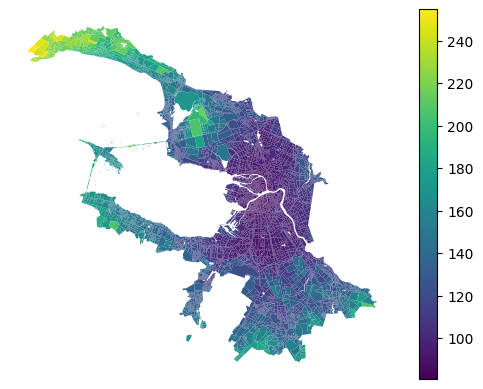

In [70]:
blocks.plot(column='area_accessibility', legend=True).set_axis_off()

In [71]:
blocks = blocks.drop(columns='cluster')

In [72]:
# 1. Выведем все dtypes
print(blocks.dtypes)

# 2. Отберём «чисто» категориальные (object / category)
cat_cols = blocks.select_dtypes(include=['object','category']).columns.tolist()
print("Категориальные по dtype:", cat_cols)

# 3. Часто к категориальным относят и числовые колонки с малым числом уникальных значений.
#    Например, если уникальных значений меньше 10:
low_cardinality = [
    col for col in blocks.select_dtypes(include=['int64','float64']).columns
    if blocks[col].nunique() < 10
]
print("Возможно категориальные по низкой кардинальности:", low_cardinality)


geometry              geometry
residential            float64
business               float64
recreation             float64
industrial             float64
                        ...   
osr                    float64
share_living           float64
share_non_living       float64
morphotype              object
area_accessibility     float64
Length: 150, dtype: object
Категориальные по dtype: ['land_use', 'morphotype']
Возможно категориальные по низкой кардинальности: ['count_school', 'count_kindergarten', 'count_hospital', 'count_polyclinic', 'count_swimming_pool', 'count_theatre', 'count_museum', 'count_cinema', 'count_mall', 'count_supermarket', 'count_cemetery', 'count_religion', 'count_market', 'count_university', 'count_fuel', 'count_beach', 'count_train_building', 'capacity_lawyer', 'count_lawyer', 'capacity_subway_entrance', 'count_subway_entrance', 'count_multifunctional_center', 'count_government', 'capacity_recruitment', 'count_recruitment', 'count_zoo', 'capacity_circus', 'cou

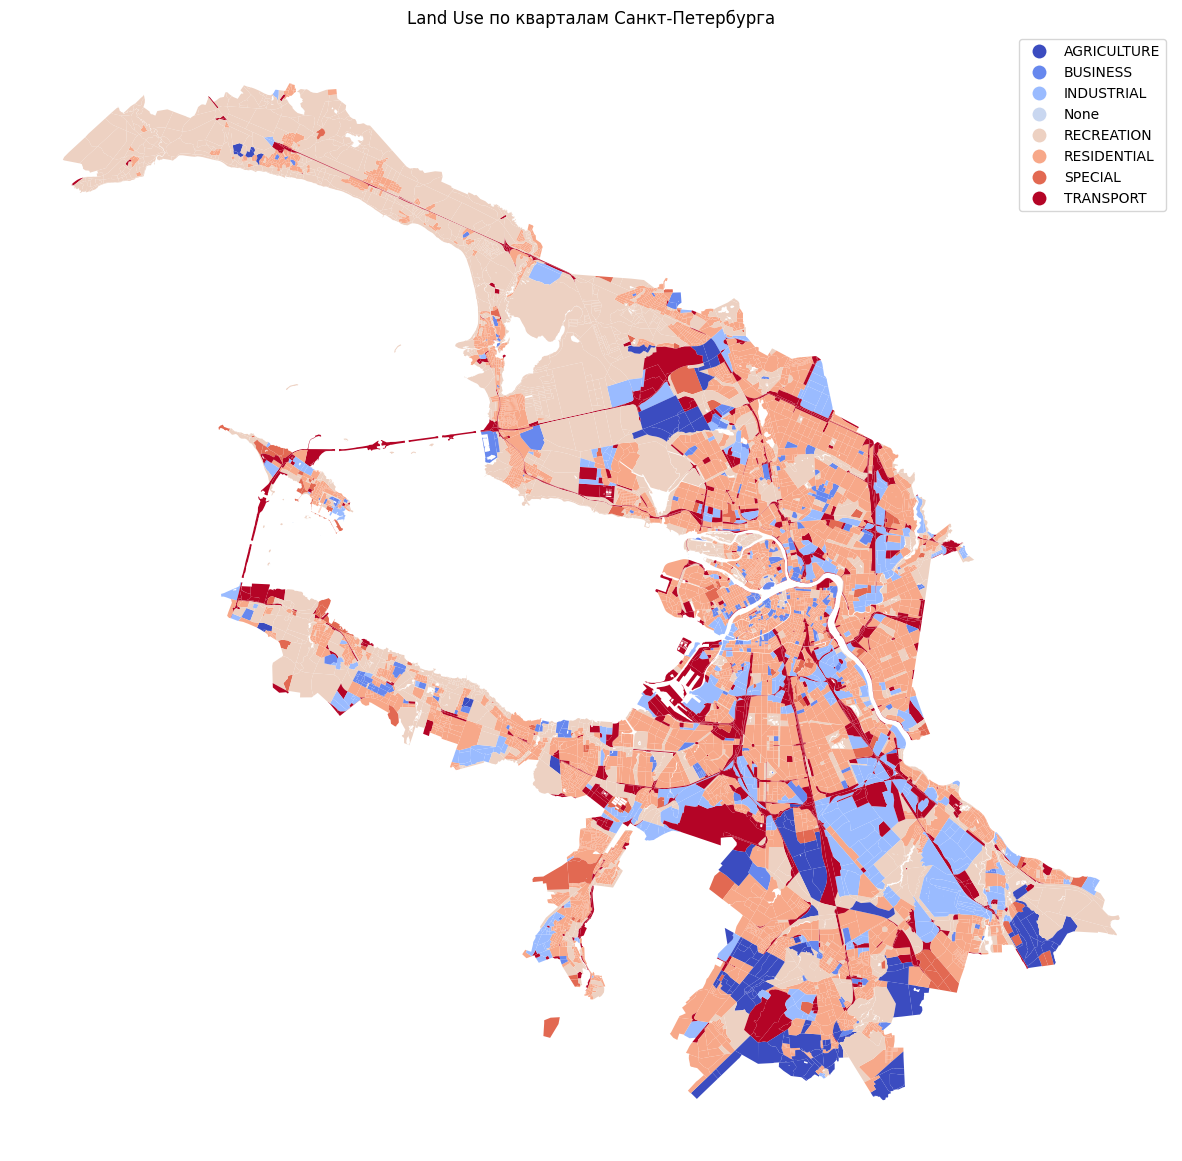

In [73]:
# Картируем лог-цену
blocks.plot(
    column='land_use',
    legend=True,
    figsize=(15,15),
    cmap='coolwarm'
).set_axis_off()
plt.title('Land Use по кварталам Санкт-Петербурга')

plt.show()

In [74]:
import pandas as pd

# 1. Отбираем числовые столбцы и фильтруем
num = blocks.select_dtypes(include=['number'])
num = num[num['log_price'] > 1]

# 2. Считаем count + статистики
agg_stats = num.agg(['count', 'min', 'max', 'mean', 'median', 'std']).T

# 3. Переименовываем столбцы
agg_stats.index.name = 'Variable'
agg_stats = agg_stats.rename(columns={
    'count':  'Count',
    'min':    'Min',
    'max':    'Max',
    'mean':   'Mean',
    'median': 'Median',
    'std':    'SD'
})

# 4. Приводим Count к int
agg_stats['Count'] = agg_stats['Count'].astype(int)

# 5. Округляем остальные метрики
for col in ['Min','Max','Mean','Median','SD']:
    agg_stats[col] = agg_stats[col].round(2)

# 6. Настраиваем глобальный формат для float
pd.options.display.float_format = '{:,.2f}'.format

# 7. Показываем результат
agg_stats


/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/pandas/core/nanops.py:1016: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


Count   Min    Max   Mean  Median    SD
Variable                                                   
residential          8703  0.00   1.00   0.51    0.68  0.43
business             8703  0.00   1.00   0.03    0.00  0.15
recreation           8703  0.00   1.00   0.18    0.00  0.33
industrial           8703  0.00   1.00   0.05    0.00  0.19
transport            8703  0.00   1.00   0.18    0.07  0.28
...                   ...   ...    ...    ...     ...   ...
l                    8703  0.00  26.40   2.24    1.25  2.69
osr                  8703  0.05    inf    inf    8.78   NaN
share_living         7238  0.00  17.16   1.20    0.70  1.76
share_non_living     7238  0.10  17.92   1.49    1.00  1.34
area_accessibility   8703 80.85 254.73 120.82  117.18 28.72

[147 rows x 6 columns]

In [75]:
blocks_default = blocks.copy()

In [76]:
# blocks = blocks_default[blocks_default['land_use'] == 'RESIDENTIAL'].copy()

In [77]:
blocks = blocks[blocks['log_total_price'] > 0].copy()
blocks = blocks.reset_index(drop=True)
blocks

geometry  residential  \
0     POLYGON ((352083.617 6633950.146, 352240.448 6...         0.10   
1     POLYGON ((346700.642 6618453.176, 346681.107 6...         1.00   
2     POLYGON ((347043.363 6618261.219, 347042.608 6...         0.73   
3     POLYGON ((354879.039 6618859.116, 354845.405 6...         0.45   
4     POLYGON ((347215.933 6646341.789, 347245.429 6...         0.11   
...                                                 ...          ...   
8753  POLYGON ((346635.461 6647492.048, 346473.426 6...         0.94   
8754  POLYGON ((346361.221 6647603.446, 346328.072 6...         0.13   
8755  POLYGON ((344109.285 6649134.367, 344000.209 6...         0.00   
8756  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
8757  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
0         0.00        0.08        0.00       0.40     0.00         0.42   
1         0.00        0.00        0.00       0.00     0.00         0.00   
2         0.00        0.27        0.00       0.00     0.00         0.00   
3         0.00        0.00        0.00       0.14     0.00         0.40   
4         0.00        0.00        0.77       0.06     0.00         0.00   
...        ...         ...         ...        ...      ...          ...   
8753      0.00        0.00        0.00       0.06     0.00         0.00   
8754      0.00        0.27        0.00       0.61     0.00         0.00   
8755      0.00        0.76        0.00       0.23     0.00         0.00   
8756      0.00        0.00        0.47       0.12     0.00         0.00   
8757      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  log_price  fsi  gsi  mxi    l      osr  \
0     AGRICULTURE   0.42  ...       6.85 0.00 0.00 0.00 1.00 1,985.45   
1     RESIDENTIAL   1.00  ...       7.58 0.06 0.06 0.69 1.04    14.64   
2     RESIDENTIAL   0.73  ...       7.32 0.03 0.03 0.69 1.04    27.82   
3     RESIDENTIAL   0.45  ...       7.70 0.18 0.08 0.67 2.33     5.01   
4      INDUSTRIAL   0.77  ...       9.06 1.00 0.25 0.00 4.00     0.75   
...           ...    ...  ...        ...  ...  ...  ...  ...      ...   
8753  RESIDENTIAL   0.94  ...       9.48 1.28 0.26 0.46 4.94     0.58   
8754    TRANSPORT   0.61  ...       8.97 1.54 0.31 0.00 4.89     0.45   
8755   RECREATION   0.76  ...       7.89 0.00 0.00 0.00 1.00 2,510.80   
8756   INDUSTRIAL   0.47  ...       8.70 1.23 0.30 0.00 4.06     0.57   
8757  RESIDENTIAL   0.69  ...       9.91 0.68 0.11 0.66 6.05     1.30   

      share_living  share_non_living                morphotype  \
0             0.00              1.00  low-rise non-residential   
1             0.72              0.33    individual residential   
2             0.72              0.32    individual residential   
3             1.56              0.78            low-rise model   
4             0.00              4.00  mid-rise non-residential   
...            ...               ...                       ...   
8753          2.27              2.67                  mid-rise   
8754          0.00              4.89  mid-rise non-residential   
8755          0.00              1.00  low-rise non-residential   
8756          0.00              4.06  mid-rise non-residential   
8757          4.01              2.03                  mid-rise   

      area_accessibility  
0                 113.85  
1                 145.88  
2                 148.54  
3                 132.69  
4                  99.16  
...                  ...  
8753               92.74  
8754               94.56  
8755              100.50  
8756               92.49  
8757               93.77  

[8758 rows x 150 columns]

In [78]:
list(blocks.columns)

['geometry',
 'residential',
 'business',
 'recreation',
 'industrial',
 'transport',
 'special',
 'agriculture',
 'land_use',
 'share',
 'footprint_area',
 'build_floor_area',
 'living_area',
 'non_living_area',
 'population',
 'count_buildings',
 'capacity_school',
 'count_school',
 'capacity_kindergarten',
 'count_kindergarten',
 'capacity_hospital',
 'count_hospital',
 'capacity_polyclinic',
 'count_polyclinic',
 'capacity_pitch',
 'count_pitch',
 'capacity_swimming_pool',
 'count_swimming_pool',
 'capacity_theatre',
 'count_theatre',
 'capacity_museum',
 'count_museum',
 'capacity_cinema',
 'count_cinema',
 'capacity_mall',
 'count_mall',
 'capacity_convenience',
 'count_convenience',
 'capacity_supermarket',
 'count_supermarket',
 'capacity_cemetery',
 'count_cemetery',
 'capacity_religion',
 'count_religion',
 'capacity_market',
 'count_market',
 'capacity_university',
 'count_university',
 'capacity_playground',
 'count_playground',
 'capacity_pharmacy',
 'count_pharmacy',
 'ca

In [79]:
# blocks['id'] = blocks.index
# blocks2 = blocks[['id', 'geometry']].copy()
# blocks2.explore()

In [80]:
import libpysal
from esda.moran import Moran, Moran_Local
import matplotlib.pyplot as plt
from splot.esda import lisa_cluster

# 1) Подготовка: spatial weights
# Если у вас уже есть w1 (Rook или Queen), используем его, иначе:
w1 = libpysal.weights.Queen.from_dataframe(blocks_default)
# или: w1 = libpysal.weights.Rook.from_dataframe(blocks)
w1.transform = 'r'   # row-standardization

# 2) Извлекаем вектор переменной
y = blocks_default['log_total_price'].values

# 3) Глобальный индекс Морена
moran_global = Moran(y, w1)
print("Global Moran’s I:",     round(moran_global.I,3))
print("p-value (normal):",     round(moran_global.p_norm,3))
print("z-score (normal):",     round(moran_global.z_norm,3))
print("p-value (permut.):",    round(moran_global.p_sim,3))
print("z-score (permut.):",    round(moran_global.z_sim,3))

# 4) Локальный индекс Морена
lisa = Moran_Local(y, w1)

# 5) Добавляем результаты в GeoDataFrame
blocks_default['lisa_I']   = lisa.Is          # локальные значения I
blocks_default['lisa_p']   = lisa.p_sim       # p-values по перестановкам
blocks_default['lisa_q']   = lisa.q           # квадранты (1=HH, 2=LH, 3=LL, 4=HL)
blocks_default['lisa_sig'] = lisa.p_sim < 0.05

# 6) Визуализация LISA-кластеров
fig, ax = plt.subplots(1, figsize=(15, 15))
# splot умеет сам раскрасить по четырём кластерам
lisa_cluster(lisa, blocks_default, p=0.05, ax=ax)
ax.set_title("LISA-кластеризация (p<0.05)")
ax.axis('off')
plt.show()


ModuleNotFoundError: No module named 'esda'

# CatBoost 

/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  super().__setitem__(key, value)
/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/geopandas/geodataframe.py:1819: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` ma

0:	learn: 2.1621794	test: 2.1769923	best: 2.1769923 (0)	total: 65.3ms	remaining: 8m 42s
100:	learn: 1.1072788	test: 1.1437984	best: 1.1437984 (100)	total: 1.02s	remaining: 1m 20s
200:	learn: 1.0053551	test: 1.1026832	best: 1.1026832 (200)	total: 1.94s	remaining: 1m 15s
300:	learn: 0.9287407	test: 1.0851776	best: 1.0851776 (300)	total: 2.77s	remaining: 1m 10s
400:	learn: 0.8730714	test: 1.0740021	best: 1.0740021 (400)	total: 3.61s	remaining: 1m 8s
500:	learn: 0.8288771	test: 1.0699295	best: 1.0692664 (492)	total: 4.43s	remaining: 1m 6s
600:	learn: 0.7874777	test: 1.0660202	best: 1.0655377 (591)	total: 5.24s	remaining: 1m 4s
700:	learn: 0.7518632	test: 1.0621191	best: 1.0621191 (700)	total: 6.08s	remaining: 1m 3s
800:	learn: 0.7185317	test: 1.0566930	best: 1.0566930 (800)	total: 7.09s	remaining: 1m 3s
900:	learn: 0.6925912	test: 1.0564173	best: 1.0557348 (831)	total: 8.14s	remaining: 1m 4s
Stopped by overfitting detector  (100 iterations wait)

bestTest = 1.055734768
bestIteration = 831


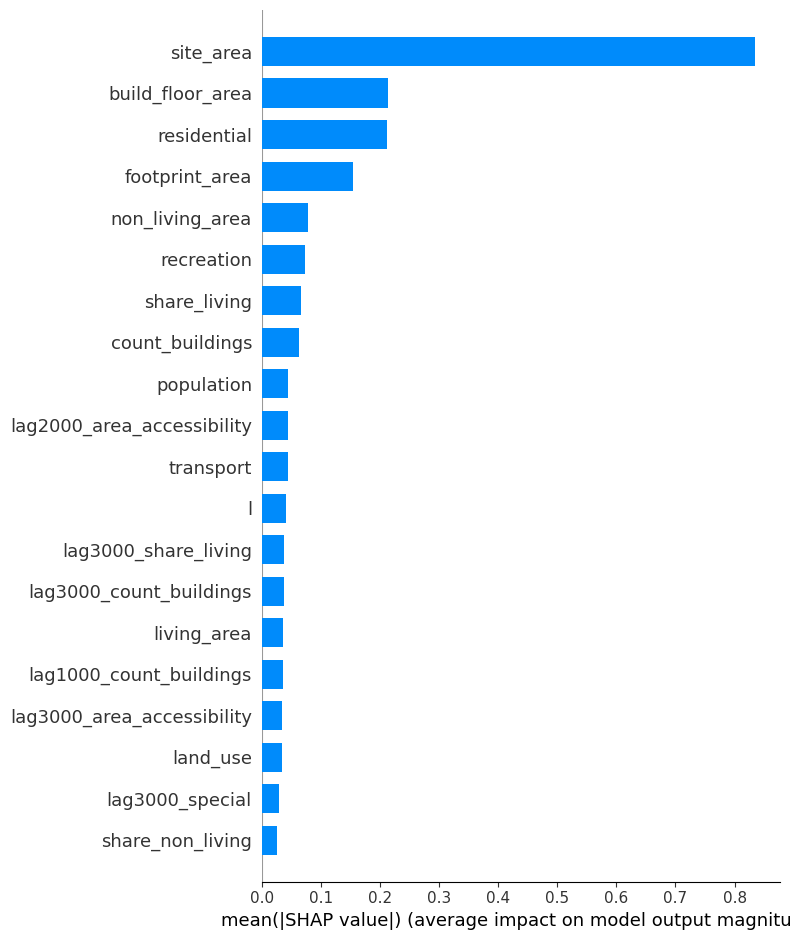

<Figure size 640x480 with 0 Axes>

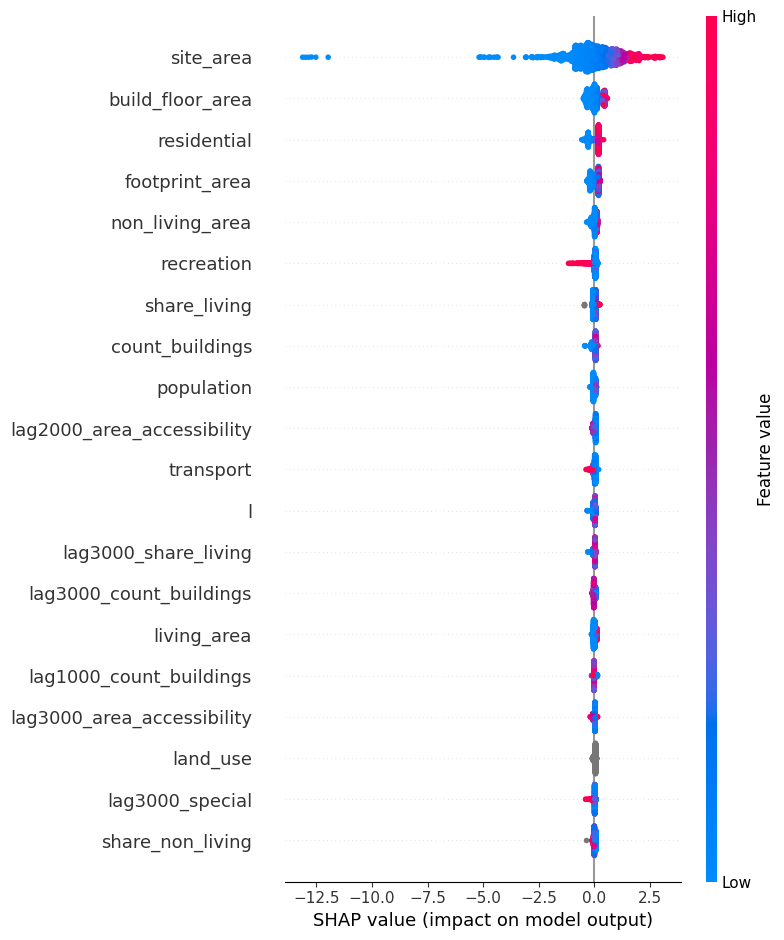

<Figure size 640x480 with 0 Axes>

In [81]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor, Pool
import shap
import matplotlib.pyplot as plt
from libpysal.weights import DistanceBand, lag_spatial

# --- 0. Исходные данные ---
# --- 0. Исходные данные ---
exclude_cols = [ 'total_cost_value',
 'price_per_sqm',
 'log_total_price',
 'log_price', 'geometry']  # примеры колонок, которые НЕ нужны

feature_cols = [c for c in blocks.columns if c not in exclude_cols]
cat_feats = ['land_use', 'morphotype']
numeric_feats = [c for c in feature_cols if c not in cat_feats]

# --- 1. Радиальные матрицы соседства ---
radius_list = [300, 500, 1000, 2000, 3000]
w_radii = {}
for r in radius_list:
    w = DistanceBand.from_dataframe(
        blocks, threshold=r, binary=True, silence_warnings=True
    )
    w.transform = 'r'  # нормализация строк
    w_radii[r] = w

# --- 2. Генерация лаг-фичей по радиусам ---
lag_cols = []
for feat in numeric_feats:
    vec = blocks[feat].fillna(blocks[feat].mean())
    for r in radius_list:
        col_name = f'lag{r}_{feat}'
        blocks[col_name] = lag_spatial(w_radii[r], vec)
        lag_cols.append(col_name)

# (опционально) число соседей по каждому радиусу
for r in radius_list:
    n_col = f'n_neighbors_{r}'
    blocks[n_col] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
    lag_cols.append(n_col)

# --- 3. Финальный список фичей и train/test split ---
all_feats = feature_cols + lag_cols
X = blocks[all_feats]
y = blocks['log_total_price']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# --- 4. Предобработка категориальных фичей ---
cat_features = ['land_use', 'morphotype']
for df in (X_train, X_test):
    df['land_use'] = df['land_use'].fillna('missing').astype(str).astype('category')
    df['morphotype'] = df['morphotype'].fillna('missing').astype(str).astype('category')

cat_feature_indices = [X_train.columns.get_loc(c) for c in cat_features]

# --- 5. Pool для CatBoost ---
train_pool = Pool(data=X_train, label=y_train, cat_features=cat_feature_indices)
test_pool = Pool(data=X_test, label=y_test, cat_features=cat_feature_indices)

# --- 6. Обучение модели ---
model = CatBoostRegressor(
    iterations=8000,
    learning_rate=0.05,
    depth=5,
    eval_metric='RMSE',
    random_seed=42,
    verbose=100
)
model.fit(train_pool, eval_set=test_pool, early_stopping_rounds=100)

# --- 7. Оценка на тесте ---
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R²   = {r2:.4f}")
print(f"MAE  = {mae:.4f}")
print(f"RMSE = {rmse:.4f}")

# --- 8. SHAP-анализ ---
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

# 8.1 Глобальная важность
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.tight_layout()
plt.show()

# 8.2 Beeswarm
shap.summary_plot(shap_values, X_test)
plt.tight_layout()
plt.show()


In [95]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from libpysal.weights import lag_spatial
from matplotlib.lines import Line2D
from matplotlib.transforms import offset_copy

def plot_scenario_with_radii(
    blocks, w_radii, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    radius_list = sorted(w_radii.keys())

    # 0) сбор соседей
    radius_ids = {}
    prev = set()
    for r in radius_list:
        ids = set(w_radii[r].neighbors.get(target_idx, [])) - prev
        radius_ids[r] = sorted(ids)
        prev |= ids
    idxs         = [target_idx] + [i for r in radius_list for i in radius_ids[r]]
    neighbor_idxs = [i for i in idxs if i != target_idx]

    # 1) лаги до
    blocks_base = blocks.copy()
    lag_cols, gm = [], blocks_base[numeric_feats].mean()
    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_base[col] = lag_spatial(w_radii[r], vec)
            lag_cols.append(col)
    for r in radius_list:
        ncol = f'n_neighbors_{r}'
        blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
        lag_cols.append(ncol)
    all_feats = orig_feats + lag_cols

    Xb = blocks_base.loc[idxs, all_feats].copy()
    Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
    Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
    preds_before     = model.predict(Xb)

    # 2) изменения + лаги после
    blocks_scn = blocks_base.copy()
    for feat, val in changes.items():
        blocks_scn.at[target_idx, feat] = val
    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_scn[col] = lag_spatial(w_radii[r], vec)

    Xa = blocks_scn.loc[idxs, all_feats].copy()
    Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
    Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
    preds_after      = model.predict(Xa)

    # 3) собираем gdf
    gdf = blocks_scn.loc[idxs].copy()
    gdf['pred_before'] = preds_before
    gdf['pred_after']  = preds_after
    gdf['log_diff']    = gdf['pred_after'] - gdf['pred_before']
    gdf['pct_change']  = (np.exp(gdf['log_diff']) - 1) * 100

    # 4) Текстовый отчёт (восстановленный)
    def ntype(i):
        if i == target_idx: return 'target'
        for r in radius_list:
            if i in radius_ids[r]: return f'radius_{r}m'
        return 'other'

    print("Δ цены в процентах (после − до):")
    for i, row in gdf.iterrows():
        b = row['pred_before']
        a = row['pred_after']
        d = row['log_diff']
        p = row['pct_change']
        print(
            f" • {i} ({ntype(i)}): "
            f"{b:.3f} → {a:.3f} "
            f"(Δ {d:+.3f} log, {p:+.1f}%)"
        )
    # 6) Сводная статистика по радиусам
    stats = []
    for r in radius_list:
        ids = radius_ids[r]
        if ids:
            mean_pct = gdf.loc[ids, 'pct_change'].mean()
            std_pct = gdf.loc[ids, 'pct_change'].std()
            stats.append((r, mean_pct, std_pct, len(ids)))
        else:
            stats.append((r, np.nan, np.nan, 0))

    print("\nСреднее изменение цены по радиусам:")
    for r, m, s, n in stats:
        print(f" • Радиус {r}м: среднее {m:+.1f}%, std {s:.1f}, участков {n}")

    # ————— добавляем вывод итогового среднего —————
    # собираем всех соседей во всех радиусах
    all_neighbor_ids = [i for r in radius_list for i in radius_ids[r]]
    if all_neighbor_ids:
        overall_mean = gdf.loc[all_neighbor_ids, 'pct_change'].mean()
        overall_std = gdf.loc[all_neighbor_ids, 'pct_change'].std()
        total_n = len(all_neighbor_ids)
        print(f"\nИтоговое среднее изменение цены по всем соседям: "
              f"{overall_mean:+.1f}% (std {overall_std:.1f}%, участков {total_n})")
    else:
        print("\nНет соседей для расчёта итогового среднего.")
    # 5) Визуализация
    fig, ax = plt.subplots(figsize=(25, 20))

    # 5.1 цвет только соседей
    vmin = gdf.loc[neighbor_idxs, 'pct_change'].min()
    vmax = gdf.loc[neighbor_idxs, 'pct_change'].max()
    gdf.loc[neighbor_idxs].plot(
        ax=ax, column='pct_change', cmap='coolwarm',
        vmin=vmin, vmax=vmax, legend=True,
        edgecolor='black', linewidth=0.5, zorder=1
    )

    # 5.2 обводки и подписи
    from matplotlib.lines import Line2D
    from matplotlib.transforms import offset_copy

    colors = ['blue', 'green', 'orange', 'purple', 'brown']
    for color, r in zip(colors, radius_list):
        ids = radius_ids[r]
        if ids:
            gdf.loc[ids].boundary.plot(ax=ax, color=color, linewidth=1.5, zorder=2)

    gdf.loc[[target_idx]].boundary.plot(
        ax=ax, edgecolor='red', linewidth=2.5, zorder=3
    )

    for i, row in gdf.iterrows():
        x, y = row.geometry.centroid.coords[0]
        ax.text(x, y, f"{row['pct_change']:+.1f}%", ha='center', va='center',
                fontsize=9, fontweight='bold', zorder=4)
        ax.text(x, y, str(row['land_use']),
                ha='center', va='center', fontsize=6, zorder=4,
                transform=offset_copy(ax.transData, fig=fig, y=-10, units='points'))

    ax.axis('off')
    ax.set_title('Изменение цены в процентах (after − before)', pad=12)
    plt.tight_layout()
    plt.show()


In [ ]:
# plot_scenario_with_radii(
#     blocks=blocks,
#     w_radii=w_radii,          # это словарь {100: w100, 500: w500, ...}
#     model=model,
#     orig_feats=feature_cols,
#     numeric_feats=numeric_feats,
#     target_idx=6720,
#     changes={
#         'capacity_school' :5000,
#         'count_school': 2,
#     }
# )

Δ цены в процентах (после − до):
 • 4307 (target): 20.922 → 21.044 (Δ +0.122 log, +13.0%)
 • 4306 (radius_300m): 20.796 → 20.786 (Δ -0.010 log, -1.0%)
 • 4308 (radius_300m): 20.973 → 20.966 (Δ -0.007 log, -0.7%)
 • 3630 (radius_500m): 19.981 → 19.977 (Δ -0.004 log, -0.4%)
 • 4309 (radius_500m): 21.204 → 21.201 (Δ -0.004 log, -0.4%)
 • 4317 (radius_500m): 20.414 → 20.410 (Δ -0.004 log, -0.4%)
 • 4319 (radius_500m): 19.877 → 19.884 (Δ +0.007 log, +0.7%)
 • 4338 (radius_500m): 19.484 → 19.480 (Δ -0.003 log, -0.3%)
 • 4339 (radius_500m): 21.015 → 21.011 (Δ -0.004 log, -0.4%)
 • 4343 (radius_500m): 20.894 → 20.887 (Δ -0.007 log, -0.7%)
 • 5084 (radius_500m): 18.873 → 18.875 (Δ +0.002 log, +0.2%)
 • 7792 (radius_500m): 19.996 → 19.992 (Δ -0.004 log, -0.4%)
 • 67 (radius_1000m): 18.928 → 18.938 (Δ +0.010 log, +1.0%)
 • 164 (radius_1000m): 19.293 → 19.297 (Δ +0.004 log, +0.4%)
 • 165 (radius_1000m): 19.503 → 19.512 (Δ +0.009 log, +0.9%)
 • 166 (radius_1000m): 19.363 → 19.363 (Δ +0.000 log, +0.

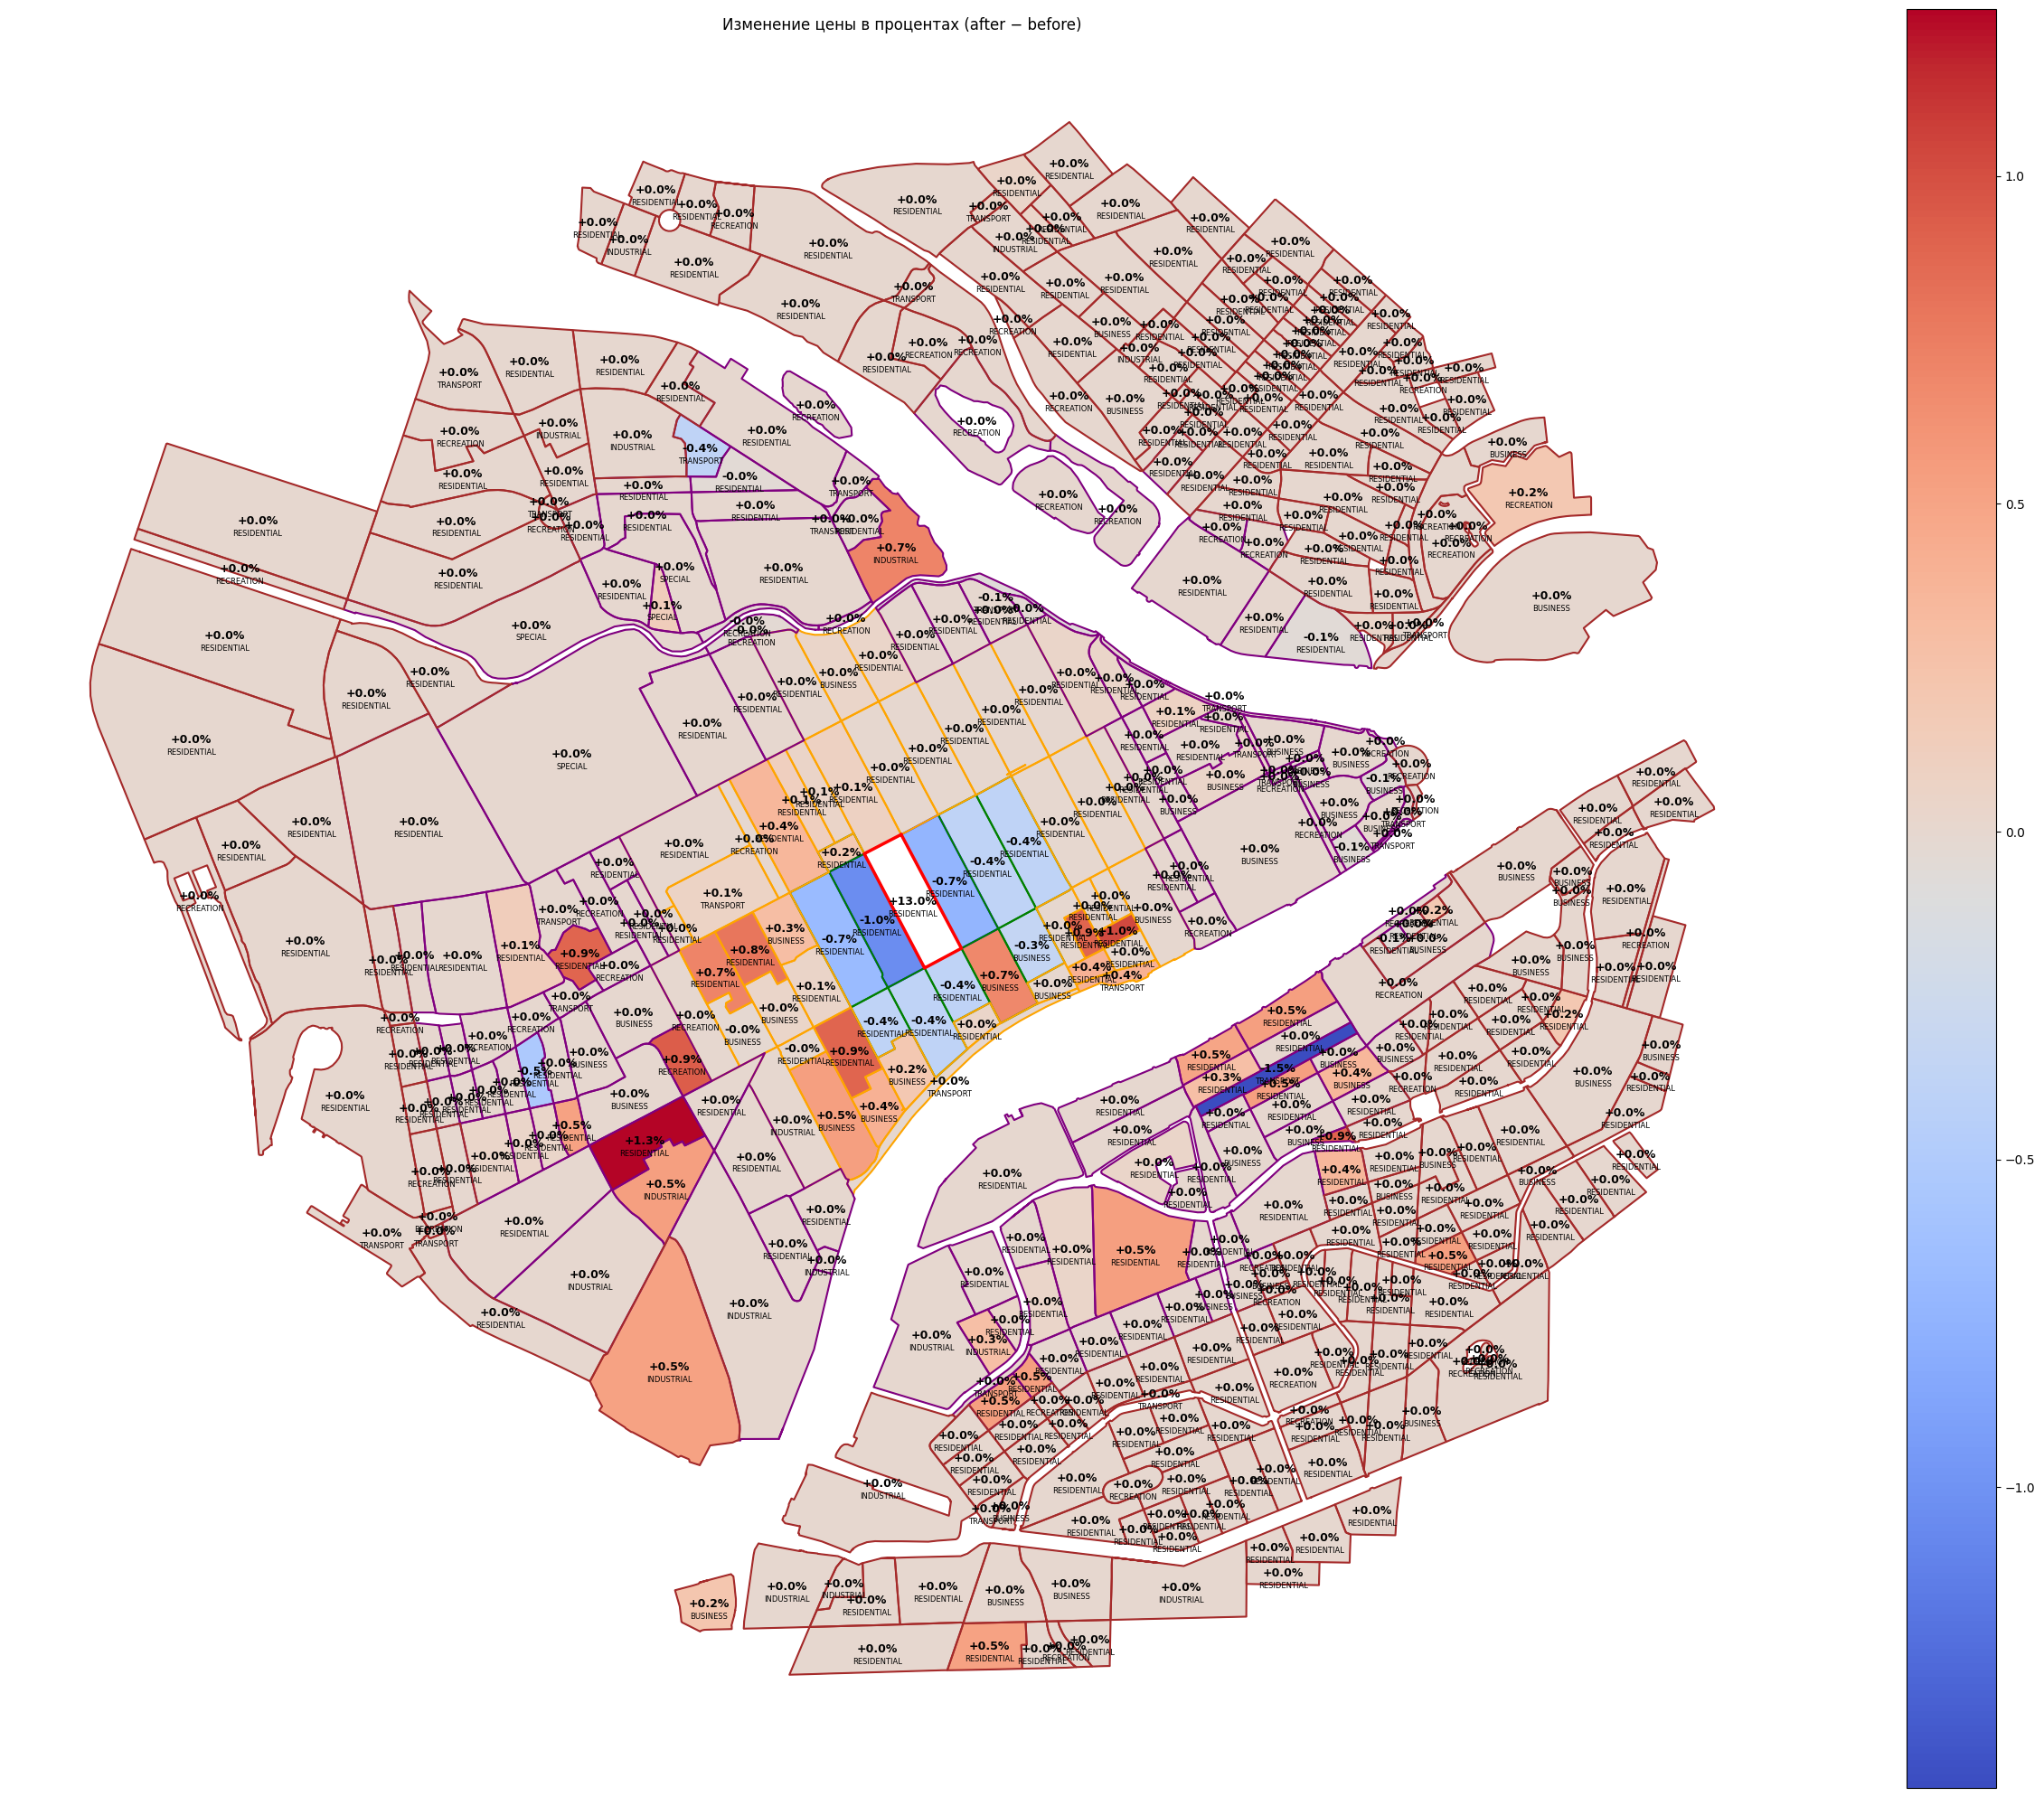

In [99]:
plot_scenario_with_radii(
    blocks=blocks,
    w_radii=w_radii,          # это словарь {100: w100, 500: w500, ...}
    model=model,
    orig_feats=feature_cols,
    numeric_feats=numeric_feats,
    target_idx=4307,
    changes={
        'land_use': 'RESIDENTIAL',
        'share': 0.95,
        'footprint_area': 49039.24,
        'build_floor_area': 230279.19,
        'living_area': 155896.85,
        'population': 5168,
        'fsi': 2.80,
        'mxi': 0.68,
        'l': 6.93,
        'osr': 0.21,
        'share_living': 4.69
    }
)


In [92]:
# ------------ 3. Функция визуализации ------------
def plot_scenario_with_radii(
    blocks, w_radii, model,
    orig_feats, numeric_feats,
    target_idx, changes
):
    radius_list = sorted(w_radii.keys())

    # --- 0) Определяем соседей ---
    radius_ids = {}
    prev = set()
    for r in radius_list:
        ids = set(w_radii[r].neighbors.get(target_idx, [])) - prev
        radius_ids[r] = sorted(ids)
        prev |= ids

    # целевой и список всех соседей
    involved = [target_idx] + [i for r in radius_list for i in radius_ids[r]]
    # только соседи без target
    neighbor_idxs = [i for i in involved if i != target_idx]

    # --- 1) Лаг-признаки до изменений ---
    blocks_base = blocks.copy()
    lag_cols = []
    gm = blocks_base[numeric_feats].mean()
    for feat in numeric_feats:
        vec = blocks_base[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_base[col] = lag_spatial(w_radii[r], vec)
            lag_cols.append(col)
    for r in radius_list:
        ncol = f'n_neighbors_{r}'
        blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
        lag_cols.append(ncol)
    all_feats = orig_feats + lag_cols

    Xb = blocks_base.loc[involved, all_feats].copy()
    Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
    Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
    before = model.predict(Xb)

    # --- 2) Вносим изменения и пересчитываем лаги ---
    blocks_scn = blocks_base.copy()
    for feat, val in changes.items():
        blocks_scn.at[target_idx, feat] = val
    for feat in numeric_feats:
        vec = blocks_scn[feat].fillna(gm[feat])
        for r in radius_list:
            col = f'lag{r}_{feat}'
            blocks_scn[col] = lag_spatial(w_radii[r], vec)

    Xa = blocks_scn.loc[involved, all_feats].copy()
    Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
    Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
    after = model.predict(Xa)

    # 3) Рассчитываем pct_change только для involved
    pct = (np.exp(after - before) - 1) * 100
    gdf = blocks_scn.copy()
    gdf['pct_change'] = np.nan
    gdf.loc[involved, 'pct_change'] = pct

    # 4) Визуализация
    fig, ax = plt.subplots(figsize=(25, 20))

    # 4.1: серый фон для всех кварталов
    blocks.plot(ax=ax, color='lightgrey', edgecolor='white', linewidth=0.2, zorder=0)

    # 4.2: цветная заливка только для соседей
    # вычисляем scale только по соседям
    vmin = gdf.loc[neighbor_idxs, 'pct_change'].min()
    vmax = gdf.loc[neighbor_idxs, 'pct_change'].max()

    gdf.loc[neighbor_idxs].plot(
        ax=ax,
        column='pct_change',
        cmap='coolwarm',
        vmin=vmin, vmax=vmax,       # теперь без target_idx
        legend=True,                # убрать, если не нужна цветовая шкала
        edgecolor='black',
        linewidth=0.5,
        zorder=1
    )

    # 4.3: рамка целевого участка
    gdf.loc[[target_idx]].boundary.plot(
        ax=ax,
        edgecolor='red',
        linewidth=2.5,
        zorder=2
    )

    ax.axis('off')
    ax.set_title('Изменение цены (в процентах)', pad=12)
    plt.tight_layout()
    plt.show()


Δ цены в процентах (после − до):
 • 4307 (target): 20.922 → 20.922 (Δ +0.000 log, +0.0%)
 • 4306 (radius_300m): 20.796 → 20.780 (Δ -0.016 log, -1.6%)
 • 4308 (radius_300m): 20.973 → 20.962 (Δ -0.011 log, -1.1%)
 • 3630 (radius_500m): 19.981 → 19.992 (Δ +0.011 log, +1.1%)
 • 4309 (radius_500m): 21.204 → 21.185 (Δ -0.019 log, -1.9%)
 • 4317 (radius_500m): 20.414 → 20.425 (Δ +0.011 log, +1.1%)
 • 4319 (radius_500m): 19.877 → 19.877 (Δ +0.000 log, +0.0%)
 • 4338 (radius_500m): 19.484 → 19.484 (Δ +0.000 log, +0.0%)
 • 4339 (radius_500m): 21.015 → 21.000 (Δ -0.014 log, -1.4%)
 • 4343 (radius_500m): 20.894 → 20.905 (Δ +0.011 log, +1.1%)
 • 5084 (radius_500m): 18.873 → 18.884 (Δ +0.011 log, +1.1%)
 • 7792 (radius_500m): 19.996 → 19.996 (Δ +0.000 log, +0.0%)
 • 67 (radius_1000m): 18.928 → 18.931 (Δ +0.003 log, +0.3%)
 • 164 (radius_1000m): 19.293 → 19.296 (Δ +0.003 log, +0.3%)
 • 165 (radius_1000m): 19.503 → 19.503 (Δ +0.000 log, +0.0%)
 • 166 (radius_1000m): 19.363 → 19.366 (Δ +0.003 log, +0.3

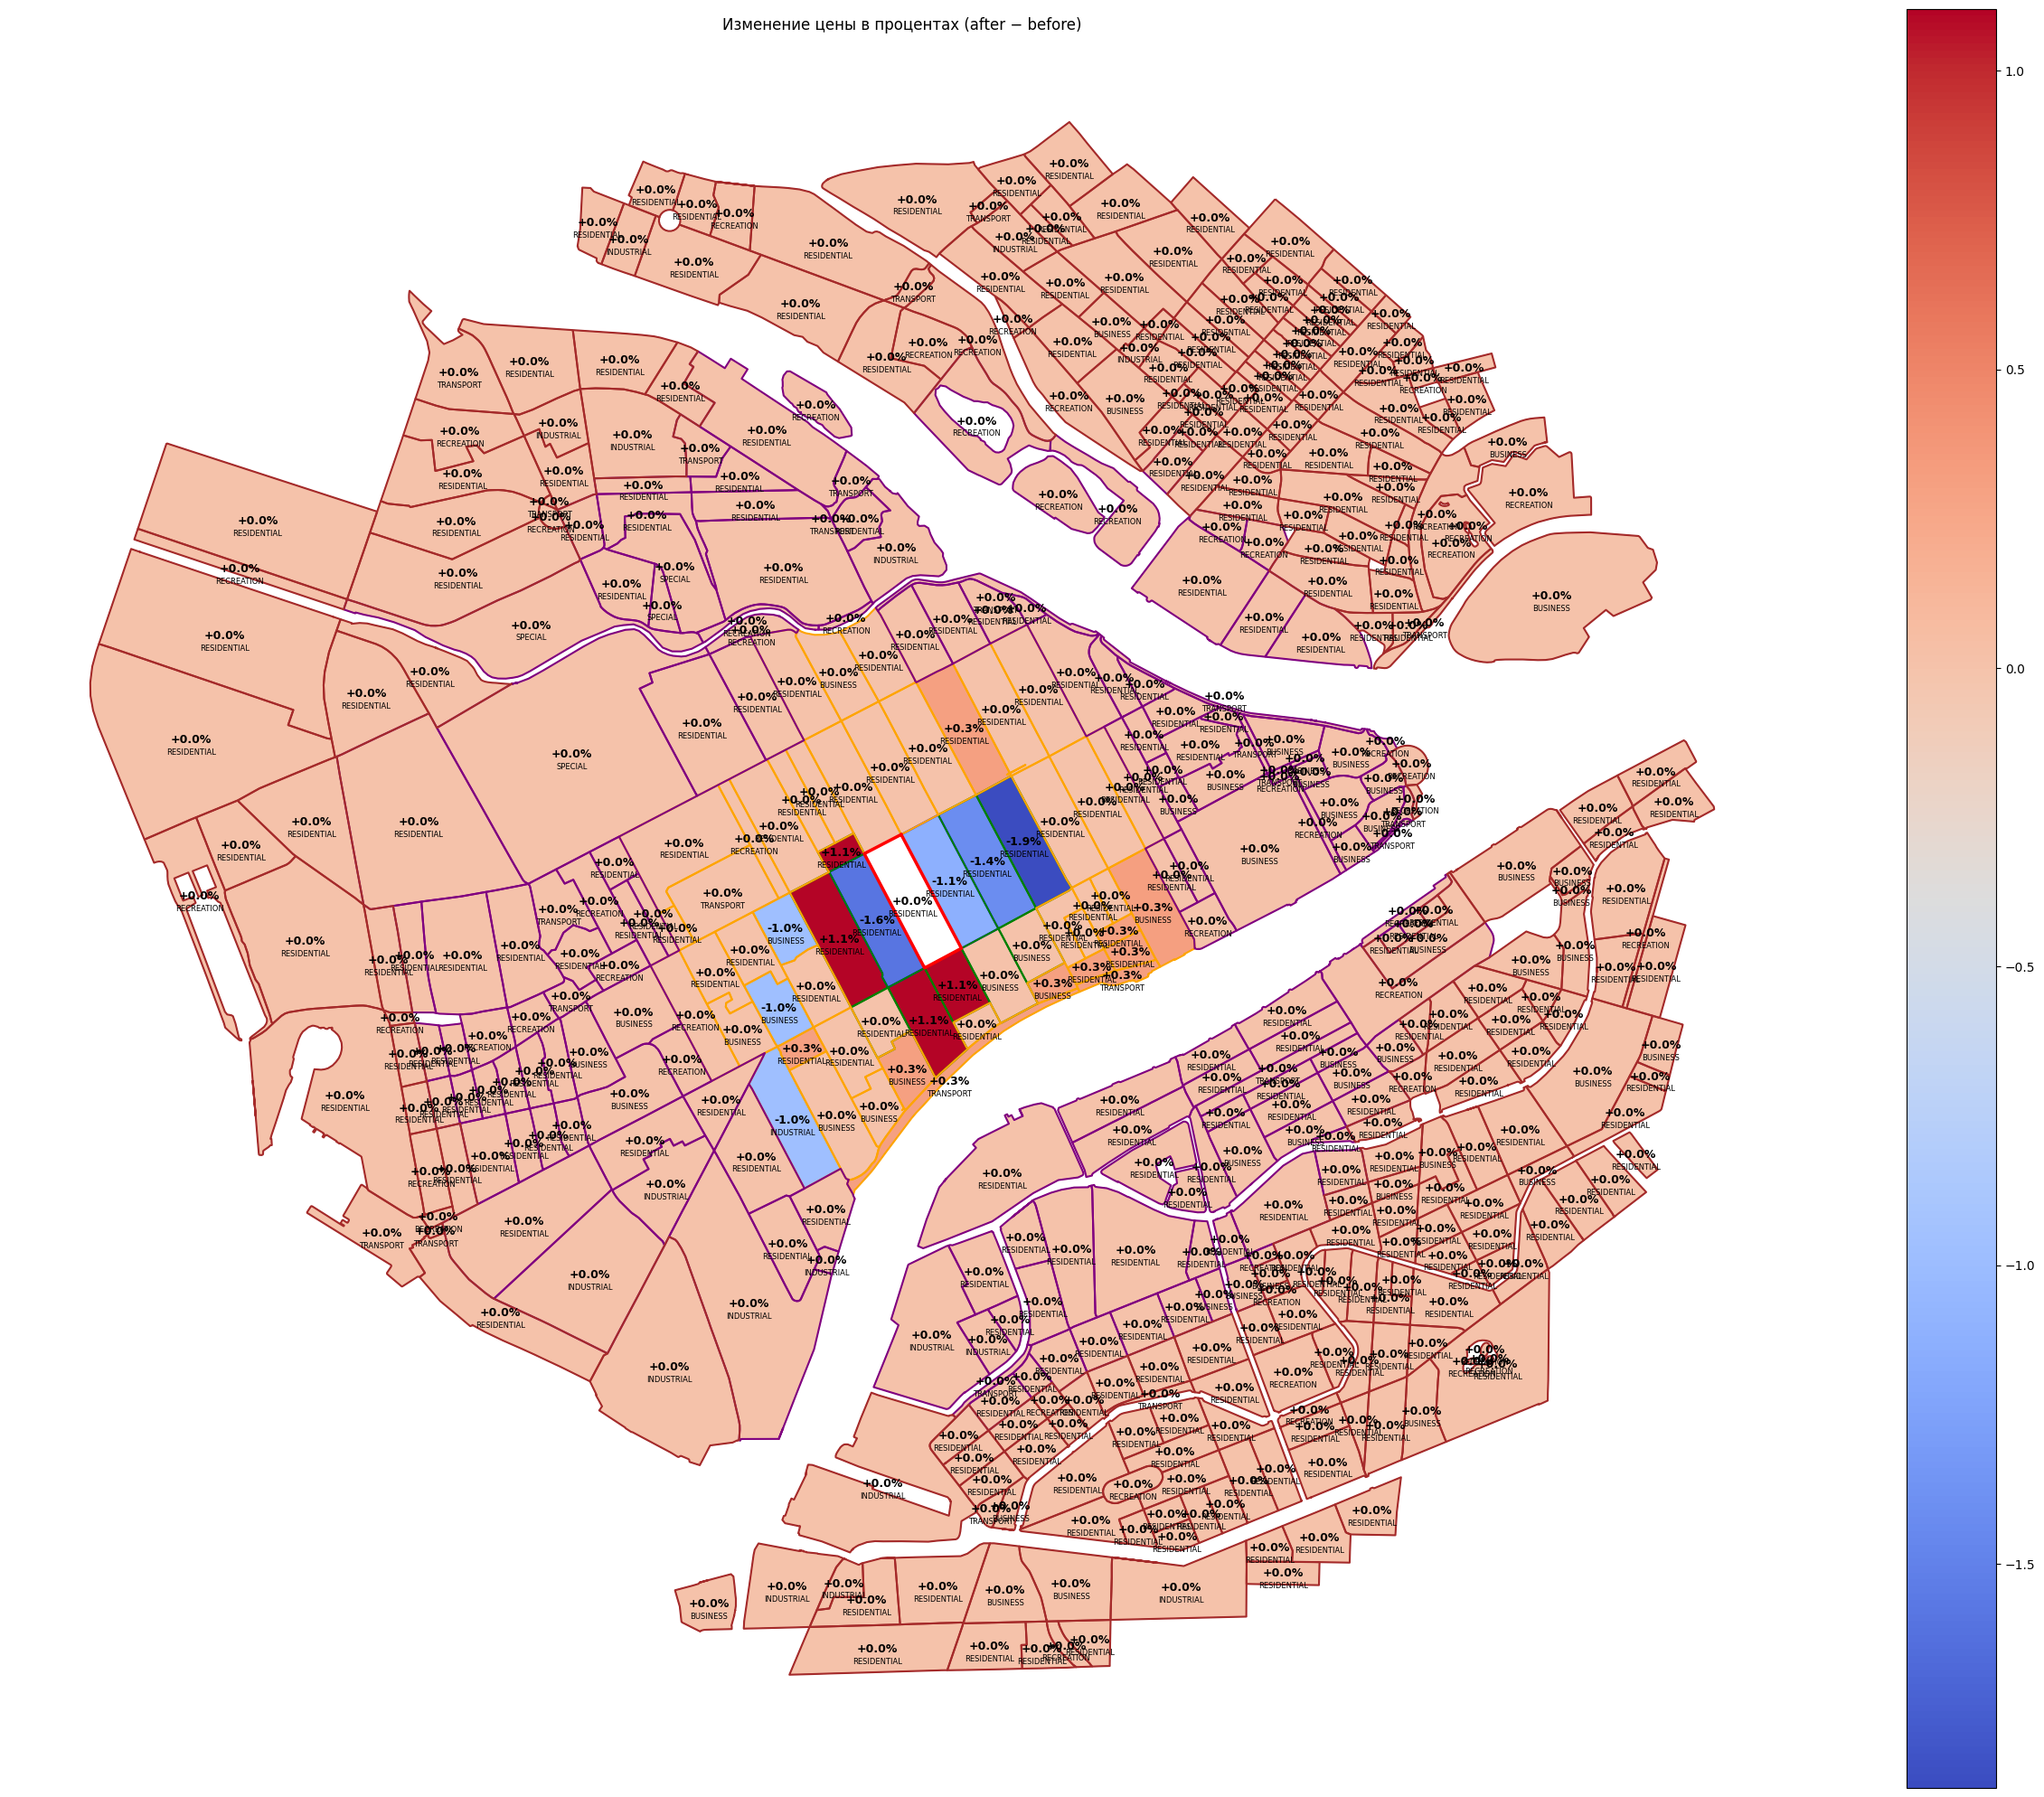

In [98]:
plot_scenario_with_radii(
    blocks=blocks,
    w_radii=w_radii,          # это словарь {100: w100, 500: w500, ...}
    model=model,
    orig_feats=feature_cols,
    numeric_feats=numeric_feats,
    target_idx=4307,
    changes={
        'capacity_school' :5000,
        'count_school': 2,
    }
)

In [104]:
import numpy as np
import pandas as pd
import geopandas as gpd
from catboost import CatBoostRegressor
from libpysal.weights import DistanceBand, lag_spatial

# ------------ 0. Задаём параметры сценария ------------
# Индекс целевого полигона
target_idx = 4307

# Словарь изменений, которые хотим внести
changes = {
    'capacity_school': 5000,
    'count_school': 2,
}

# ------------ 1. Загружаем данные и модель ------------
# Предполагаем, что blocks уже загружен:
# blocks = gpd.read_file('blocks.geojson')

model = CatBoostRegressor()
model.load_model('/home/mvin/prostor-examples/examples/data/catboost_model.cbm')

# Списки фичей
feature_cols = [
    'residential','business','recreation','industrial','transport','special',
    'agriculture','land_use','share','footprint_area','build_floor_area',
    'living_area','non_living_area','population','site_area','fsi','gsi',
    'mxi','l','morphotype','area_accessibility'
]
numeric_feats = [c for c in feature_cols if c not in ['land_use','morphotype']]

# Радиусы для соседства
radius_list = [300, 500, 1000, 2000, 3000]

# ------------ 2. Строим матрицы соседства ------------
w_radii = {}
for r in radius_list:
    w = DistanceBand.from_dataframe(blocks, threshold=r, binary=True, silence_warnings=True)
    w.transform = 'r'
    w_radii[r] = w

# ------------ 3. Расчёт лаг-признаков и предсказаний ------------

# 3.1. Копируем blocks и считаем лаги
blocks_base = blocks.copy()
lag_cols = []
gm = blocks_base[numeric_feats].mean()

for feat in numeric_feats:
    vec = blocks_base[feat].fillna(gm[feat])
    for r in radius_list:
        col = f'lag{r}_{feat}'
        blocks_base[col] = lag_spatial(w_radii[r], vec)
        lag_cols.append(col)

for r in radius_list:
    ncol = f'n_neighbors_{r}'
    blocks_base[ncol] = pd.Series({i: len(nb) for i, nb in w_radii[r].neighbors.items()})
    lag_cols.append(ncol)

all_feats = feature_cols + lag_cols

# 3.2. Определяем индексы target + соседей
radius_ids = {}
prev = set()
for r in radius_list:
    nbrs = set(w_radii[r].neighbors.get(target_idx, [])) - prev
    radius_ids[r] = sorted(nbrs)
    prev |= nbrs

idxs = [target_idx] + [i for r in radius_list for i in radius_ids[r]]

# 3.3. Предсказания ДО изменений
Xb = blocks_base.loc[idxs, all_feats].copy()
Xb['land_use']   = Xb['land_use'].fillna('missing').astype('category')
Xb['morphotype'] = Xb['morphotype'].fillna('missing').astype('category')
preds_before = model.predict(Xb)

# 3.4. Вносим изменения и пересчитываем лаги
blocks_scn = blocks_base.copy()
for feat, val in changes.items():
    blocks_scn.at[target_idx, feat] = val

for feat in numeric_feats:
    vec = blocks_scn[feat].fillna(gm[feat])
    for r in radius_list:
        col = f'lag{r}_{feat}'
        blocks_scn[col] = lag_spatial(w_radii[r], vec)

Xa = blocks_scn.loc[idxs, all_feats].copy()
Xa['land_use']   = Xa['land_use'].fillna('missing').astype('category')
Xa['morphotype'] = Xa['morphotype'].fillna('missing').astype('category')
preds_after = model.predict(Xa)

# ------------ 4. Собираем итоговый GeoDataFrame ------------
gdf = blocks_scn.loc[idxs].copy()
gdf['pred_log_before']   = preds_before
gdf['pred_price_before'] = np.exp(preds_before)
gdf['pred_log_after']    = preds_after
gdf['pred_price_after']  = np.exp(preds_after)
gdf['pct_change']        = (np.exp(preds_after - preds_before) - 1) * 100

# ------------ 5. Сохраняем всё в один GeoJSON ------------
gdf.to_file('scenario_predictions.geojson', driver='GeoJSON')
print("Сохранён файл scenario_predictions.geojson")



Сохранён файл scenario_predictions.geojson


/home/mvin/blocksnet-1/.venv/lib/python3.10/site-packages/pyogrio/raw.py:723: RuntimeWarning: NaN of Infinity value found. Skipped
  ogr_write(


In [105]:
gdf

geometry  residential  \
4307  POLYGON ((347548.976 6647959.402, 347550.637 6...         0.84   
4306  POLYGON ((347400.293 6647892.387, 347400.293 6...         0.85   
4308  POLYGON ((347924.28 6647599.783, 347914.875 66...         0.86   
3630  POLYGON ((347780.046 6647522.625, 347780.046 6...         0.85   
4309  POLYGON ((348063.297 6647695.936, 348054.763 6...         0.72   
...                                                 ...          ...   
8172  POLYGON ((349804.415 6649403.173, 349771.349 6...         0.00   
8445  POLYGON ((346820.878 6650518.531, 346811.091 6...         0.83   
8447  POLYGON ((348602.81 6649678.851, 348476.292 66...         0.01   
8756  POLYGON ((346323.488 6649497.386, 346199.573 6...         0.40   
8757  POLYGON ((346670.461 6649890.747, 346543.309 6...         0.69   

      business  recreation  industrial  transport  special  agriculture  \
4307      0.00        0.09        0.00       0.07     0.00         0.00   
4306      0.00        0.09        0.00       0.06     0.00         0.00   
4308      0.00        0.09        0.00       0.05     0.00         0.00   
3630      0.01        0.11        0.00       0.03     0.00         0.00   
4309      0.00        0.15        0.00       0.13     0.00         0.00   
...        ...         ...         ...        ...      ...          ...   
8172      0.78        0.19        0.00       0.03     0.00         0.00   
8445      0.00        0.02        0.00       0.14     0.00         0.00   
8447      0.92        0.00        0.00       0.07     0.00         0.00   
8756      0.00        0.00        0.47       0.12     0.00         0.00   
8757      0.00        0.00        0.00       0.20     0.00         0.00   

         land_use  share  ...  n_neighbors_500  n_neighbors_1000  \
4307  RESIDENTIAL   0.84  ...               11                55   
4306  RESIDENTIAL   0.85  ...               10                56   
4308  RESIDENTIAL   0.86  ...               11                58   
3630  RESIDENTIAL   0.85  ...               15                49   
4309  RESIDENTIAL   0.72  ...               11                62   
...           ...    ...  ...              ...               ...   
8172     BUSINESS   0.78  ...               21                83   
8445  RESIDENTIAL   0.83  ...                6                29   
8447     BUSINESS   0.92  ...               21                72   
8756   INDUSTRIAL   0.47  ...               13                30   
8757  RESIDENTIAL   0.69  ...                9                35   

      n_neighbors_2000  n_neighbors_3000    id  pred_log_before  \
4307               210               468  4307            20.94   
4306               201               450  4306            20.76   
4308               219               479  4308            21.06   
3630               232               483  3630            20.00   
4309               232               525  4309            20.94   
...                ...               ...   ...              ...   
8172               253               504  8172            19.76   
8445               138               355  8445            19.48   
8447               262               481  8447            19.96   
8756               111               325  8756            19.61   
8757               126               348  8757            20.54   

      pred_price_before  pred_log_after  pred_price_after  pct_change  
4307   1,240,296,589.36           20.94  1,240,296,589.36        0.00  
4306   1,033,354,867.04           20.76  1,033,354,867.04        0.00  
4308   1,400,670,897.18           21.06  1,400,670,897.18        0.00  
3630     485,466,666.78           20.00    485,466,666.78        0.00  
4309   1,248,202,509.72           20.94  1,248,202,509.72        0.00  
...                 ...             ...               ...         ...  
8172     381,064,510.71           19.76    381,064,510.71        0.00  
8445     287,045,159.33           19.48    287,045,159.33        0.00  
8447     46